# DDPM & DDIM notebook

## Imports

In [1]:
!pip install torch_fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [4]:
# === Standard Libraries ===
import os
import random
import time
from collections import Counter

# === Data & Image Processing ===
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.linalg import sqrtm

# === PyTorch Core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

# === Torchvision (Transforms, Datasets, Models) ===
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

# === Transformers (HuggingFace) ===
from transformers import AutoModel, AutoTokenizer, CLIPModel, CLIPProcessor

# === Evaluation & Metrics ===
from torch_fidelity import calculate_metrics

# === Utilities ===
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gdown

## Util functions

In [5]:
def print_distribution(name, idxs):
    lbls = labels[idxs]
    dist = Counter(lbls)
    print(f"\n{name} split distribution:")
    for digit in range(10):
        print(f"Digit {digit}: {dist[digit]} samples")
    print(f"Total: {len(idxs)}")

In [6]:
def measure_sampling_time(model, method="ddpm", **kwargs):
    start = time.time()
    model.generate_samples(**kwargs)
    end = time.time()
    return end - start

In [7]:
def numeric_prompt(label): return str(label)
def digit_prompt(label): return f"digit {label}"
def long_prompt(label):
    words = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    return f"a handwritten digit {words[label]}"

## Metrics

#### FID score

In [8]:
def compute_fid_score(model, num_samples=1000, use_ddim=False, ddim_steps=50, eta=0.0):
    inception = inception_v3(pretrained=True, aux_logits=True).to(model.device)
    inception.fc = torch.nn.Identity()
    inception.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    real_dataset = MNIST(root=".", train=True, download=True, transform=transform)
    real_loader = DataLoader(real_dataset, batch_size=64, shuffle=True)

    # Gather real images
    real_images = []
    for img, _ in real_loader:
        real_images.append(img)
        if len(real_images) * 64 >= num_samples:
            break
    real_images = torch.cat(real_images)[:num_samples].to(model.device)

    # Generate synthetic samples
    prompts = [str(i % 10) for i in range(num_samples)]
    fake_images = model.sample(
        num_samples=num_samples,
        text_prompts=prompts,
        use_ddim=use_ddim,
        ddim_steps=ddim_steps,
        eta=eta
    ).to(model.device)

    # Convert fake images to 3 channels + resize
    fake_images = F.interpolate(fake_images, size=(299, 299), mode="bilinear", align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1)

    def get_features(images):
        feats = []
        with torch.no_grad():
            for i in range(0, len(images), 64):
                batch = images[i:i + 64]
                pred = inception(batch)
                feats.append(pred.cpu().numpy())
        return np.concatenate(feats, axis=0)

    real_feats = get_features(real_images)
    fake_feats = get_features(fake_images)

    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_feats, axis=0), np.cov(fake_feats, rowvar=False)
    covmean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    print(f"FID (use_ddim={use_ddim}): {fid:.4f}")
    return fid

#### Inception score

In [ ]:
def compute_inception_score(model, num_samples=1000, splits=10, use_ddim=False, ddim_steps=50, eta=0.0):
    device = model.device

    # Ініціалізація Inception
    inception = inception_v3(pretrained=True, aux_logits=True).to(device)
    inception.eval()

    # Генерація зображень
    prompts = [str(i % 10) for i in range(num_samples)]
    images = model.sample(
        num_samples=num_samples,
        text_prompts=prompts,
        use_ddim=use_ddim,
        ddim_steps=ddim_steps,
        eta=eta
    ).to(device)

    # Підготовка зображень
    images = (images.clamp(-1, 1) + 1) / 2  # нормалізація до [0, 1]
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = images.repeat(1, 3, 1, 1)

    # Прогін через Inception
    preds = []
    with torch.no_grad():
        for i in range(0, num_samples, 64):
            batch = images[i:i+64]
            logits = inception(batch)
            probs = F.softmax(logits, dim=1)
            preds.append(probs.cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    # Обчислення IS
    scores = []
    split_size = num_samples // splits
    for i in range(splits):
        part = preds[i * split_size:(i + 1) * split_size]
        py = np.mean(part, axis=0)
        kl_div = part * (np.log(part + 1e-10) - np.log(py + 1e-10))
        kl_div = np.sum(kl_div, axis=1)
        scores.append(np.exp(np.mean(kl_div)))

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"Inception Score (use_ddim={use_ddim}): {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score


#### Precision/Recall/Density/Coverage

In [ ]:
def compute_prdc_metrics(real_features, fake_features, nearest_k):

    from scipy.spatial import cKDTree

    real_tree = cKDTree(real_features)
    fake_tree = cKDTree(fake_features)

    # Кожній точці з реальних знаходимо відстані до найближчих сусідів
    real_nn_dists = real_tree.query(real_features, k=nearest_k + 1)[0][:, -1]
    fake_nn_dists = fake_tree.query(fake_features, k=nearest_k + 1)[0][:, -1]

    def precision():
        dists = real_tree.query(fake_features, k=1)[0]
        return (dists <= real_nn_dists).mean()

    def recall():
        dists = fake_tree.query(real_features, k=1)[0]
        return (dists <= fake_nn_dists).mean()

    def density():
        dists = real_tree.query(fake_features, k=nearest_k)[0]
        return (dists <= real_nn_dists[:, None]).sum() / (nearest_k * len(fake_features))

    def coverage():
        dists = real_tree.query(fake_features, k=1)[0]
        return (dists <= real_nn_dists).sum() / len(real_nn_dists)

    return {
        'precision': precision(),
        'recall': recall(),
        'density': density(),
        'coverage': coverage(),
    }


In [ ]:
def compute_prdc_score(model, num_samples=1000, nearest_k=5, use_ddim=False, ddim_steps=50, eta=0.0):
    device = model.device

    # Завантаження Inception без останнього шару
    inception = inception_v3(pretrained=True, aux_logits=True).to(device)
    inception.fc = torch.nn.Identity()
    inception.eval()

    def extract_features(images):
        feats = []
        with torch.no_grad():
            for i in range(0, len(images), 64):
                pred = inception(images[i:i+64])
                feats.append(pred.cpu().numpy())
        return np.concatenate(feats, axis=0)

    # Генерація зразків
    prompts = [str(i % 10) for i in range(num_samples)]
    samples = model.sample(
        num_samples=num_samples,
        text_prompts=prompts,
        use_ddim=use_ddim,
        ddim_steps=ddim_steps,
        eta=eta
    ).to(device)

    # Обробка фейкових зображень
    fake_images = (samples.clamp(-1, 1) + 1) / 2
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear')
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(fake_images)

    # Завантаження реальних зображень
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    mnist = MNIST(root=".", train=True, download=True, transform=transform)
    real_loader = DataLoader(mnist, batch_size=64, shuffle=True)

    real_images = []
    for x, _ in real_loader:
        real_images.append(x)
        if len(real_images) * 64 >= num_samples:
            break
    real_images = torch.cat(real_images)[:num_samples].to(device)

    # Обчислення ознак
    real_feats = extract_features(real_images)
    fake_feats = extract_features(fake_images)

    # Метрики Precision, Recall, Density, Coverage
    metrics = compute_prdc_metrics(real_feats, fake_feats, nearest_k=nearest_k)
    print(f"PRDC (use_ddim={use_ddim}):")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


#### CLIP score

In [ ]:
def compute_clip_score_for_prompt_type(model, prompt_type, samples_per_prompt=5, use_ddim=False, ddim_steps=50, eta=0.0):
    """
    Обчислює CLIP Score для моделі, яка була натренована на одному з типів prompt'ів: 'numeric', 'digit', 'long'.
    """
    from transformers import CLIPProcessor, CLIPModel

    # Підготовка CLIP
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(model.device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    to_pil = transforms.ToPILImage()
    clip_model.eval()

    # Визначаємо самі prompt-и
    prompt_map = {
        'numeric': [str(i) for i in range(10)],
        'digit': [f"digit {i}" for i in range(10)],
        'long': [f"a handwritten digit {w}" for w in [
            "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"
        ]]
    }

    assert prompt_type in prompt_map, f"Invalid prompt_type '{prompt_type}'. Choose from: {list(prompt_map.keys())}"
    prompts = prompt_map[prompt_type]

    print(f"\n📌 Evaluating CLIP score for prompt type: '{prompt_type}' (use_ddim={use_ddim})")
    all_scores = []

    for prompt in prompts:
        text_batch = [prompt] * samples_per_prompt
        images = model.sample(
            num_samples=samples_per_prompt,
            text_prompts=text_batch,
            use_ddim=use_ddim,
            ddim_steps=ddim_steps,
            eta=eta
        ).cpu()

        pil_images = [to_pil(img.squeeze(0)) for img in images]
        rgb_images = [img.resize((224, 224)).convert("RGB") for img in pil_images]

        inputs = clip_processor(text=text_batch, images=rgb_images, return_tensors="pt", padding=True).to(model.device)
        with torch.no_grad():
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            scores = logits_per_image.squeeze().cpu().numpy()
            all_scores.extend(scores)

    avg_score = float(np.mean(all_scores))
    print(f"CLIP Score for '{prompt_type}': {avg_score:.4f}")
    return avg_score


## Loading the dataset & working with text prompts

In [9]:
class MNISTTextDataset(Dataset):
    def __init__(self, transform, indices=None, targets_to_text_fn=None):
        train = MNIST(root="./data", train=True, download=True)
        test = MNIST(root="./data", train=False, download=True)
        full_data = torch.cat([train.data, test.data], dim=0)
        full_targets = torch.cat([train.targets, test.targets], dim=0)

        if indices is not None:
            full_data = full_data[indices]
            full_targets = full_targets[indices]

        self.images = full_data
        self.labels = full_targets
        self.transform = transform
        self.to_pil = ToPILImage()

        if targets_to_text_fn is None:
            self.targets_to_text_fn = lambda y: f"a handwritten digit {['zero','one','two','three','four','five','six','seven','eight','nine'][y]}"
        else:
            self.targets_to_text_fn = targets_to_text_fn

        self.texts = [self.targets_to_text_fn(label.item()) for label in self.labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.to_pil(self.images[idx])  # Convert to PIL first
        image = self.transform(image)
        text = self.texts[idx]
        return image, text

In [10]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', device='cpu', output_dim=256):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name).to(device)
        self.project = nn.Linear(self.transformer.config.hidden_size, output_dim)

    def forward(self, text_list):
        enc = self.tokenizer(text_list, return_tensors='pt', padding=True, truncation=True).to(self.device)
        out = self.transformer(**enc)
        cls = out.last_hidden_state[:, 0, :]
        return self.project(cls)

In [11]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, image_dim, text_dim, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (image_dim // heads) ** -0.5
        self.query = nn.Linear(image_dim, image_dim)
        self.key = nn.Linear(text_dim, image_dim)
        self.value = nn.Linear(text_dim, image_dim)
        self.proj = nn.Linear(image_dim, image_dim)

    def forward(self, x_img, x_txt):
        B, C, H, W = x_img.shape
        x_img_flat = x_img.view(B, C, -1).permute(0, 2, 1)
        if x_txt.dim() == 2:
            x_txt = x_txt.unsqueeze(1)
        Q = self.query(x_img_flat)
        K = self.key(x_txt)
        V = self.value(x_txt)
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = self.proj(out).permute(0, 2, 1).view(B, C, H, W)
        return out

In [12]:
def visualize_dataset_samples(dataset, num_samples=10):

    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 2.5))

    for i, idx in enumerate(indices):
        image, text = dataset[idx]
        image = image.squeeze().numpy()
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow((image + 1) / 2, cmap='gray')  # unnormalize
        ax.set_title(text, fontsize=7, wrap=True)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## UNet model

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256))
        self.cross_attn = CrossAttentionBlock(256, 256)

        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2)

        # Middle
        self.conv_mid = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_mid = nn.BatchNorm2d(256)

        # Decoder
        self.conv_up1 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn_up1 = nn.BatchNorm2d(128)
        self.dconv1 = nn.Conv2d(128 + 256, 128, 3, padding=1)
        self.bn_d1 = nn.BatchNorm2d(128)

        self.conv_up2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_up2 = nn.BatchNorm2d(64)
        self.dconv2 = nn.Conv2d(64 + 128, 64, 3, padding=1)
        self.bn_d2 = nn.BatchNorm2d(64)

        self.conv_up3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn_up3 = nn.BatchNorm2d(32)
        self.dconv3 = nn.Conv2d(32 + 1, 32, 3, padding=1)
        self.bn_d3 = nn.BatchNorm2d(32)

        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, text_emb):
        t_emb = self.time_embedding(t.unsqueeze(-1)).unsqueeze(-1).unsqueeze(-1)
        x0 = x

        x1 = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x3)

        t_emb = t_emb.expand(-1, -1, x.shape[2], x.shape[3])
        x = F.relu(self.bn_mid(self.conv_mid(x + t_emb)))
        x = x + self.cross_attn(x, text_emb)

        x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=False)
        x = F.relu(self.bn_d1(self.dconv1(torch.cat([self.bn_up1(self.conv_up1(x)), x3], dim=1))))

        x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=False)
        x = F.relu(self.bn_d2(self.dconv2(torch.cat([self.bn_up2(self.conv_up2(x)), x2], dim=1))))

        x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=False)
        x = F.relu(self.bn_d3(self.dconv3(torch.cat([self.bn_up3(self.conv_up3(x)), x0], dim=1))))

        return self.conv_out(x)


## Diffusion Model (DDPM and DDIM)

In [ ]:
class DiffusionModel:
    def __init__(self, device='cuda', timesteps=1000):
        self.device = device
        self.timesteps = timesteps
        self.model = UNet().to(device)
        self.text_encoder = TextEncoder(device=device).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

        self.beta_start = 1e-4
        self.beta_end = 0.02
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_loader = None
        self.test_loader = None
        self.train_losses = []
        self.test_losses = []

    def load_text_conditioned_data(self, train_dataset, test_dataset, batch_size=64):
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    def get_noise_for_timestep(self, t, x0):
        noise = torch.randn_like(x0)
        s1 = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        s2 = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return s1 * x0 + s2 * noise, noise

    def train(self, epochs=10, patience=3, min_delta=1e-4, save_path="output/best_model.pt"):
        start_time = time.time()
        self.train_losses = []
        self.test_losses = []

        best_test_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            epoch_start = time.time()

            train_loss = self.train_step()
            test_loss = self.test_step()
            duration = (time.time() - epoch_start) / 60

            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)

            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {duration:.2f} min")

            if best_test_loss - test_loss > min_delta:
                best_test_loss = test_loss
                patience_counter = 0
                self.save_model(save_path)
                print(f"Saved best model at epoch {epoch+1} with test loss: {test_loss:.4f}")
            else:
                patience_counter += 1
                print(f"No improvement. Patience counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        total_time = (time.time() - start_time) / 60
        print(f"\nTotal training time: {total_time:.2f} minutes")
        self.plot_loss_curves()

    def train_step(self):
        self.model.train()
        total_loss = 0.0
        for images, texts in self.train_loader:
            images = images.to(self.device)
            t = torch.randint(0, self.timesteps, (images.shape[0],), device=self.device).long()
            noisy_x, noise = self.get_noise_for_timestep(t, images)
            text_emb = self.text_encoder(texts)
            noise_pred = self.model(noisy_x, t.float() / self.timesteps, text_emb)
            loss = self.loss_fn(noise_pred, noise)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def test_step(self):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for images, texts in self.test_loader:
                images = images.to(self.device)
                t = torch.randint(0, self.timesteps, (images.size(0),), device=self.device).long()
                noisy_x, noise = self.get_noise_for_timestep(t, images)
                text_emb = self.text_encoder(texts)
                noise_pred = self.model(noisy_x, t.float() / self.timesteps, text_emb)
                loss = self.loss_fn(noise_pred, noise)
                total_loss += loss.item()
        return total_loss / len(self.test_loader)

    def sample(self, num_samples=1, text_prompts=None, use_ddim=False, ddim_steps=50, eta=0.0):
        assert text_prompts is not None and len(text_prompts) == num_samples
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(num_samples, 1, 28, 28).to(self.device)
            text_emb = self.text_encoder(text_prompts)

            if use_ddim:
                step_size = self.timesteps // ddim_steps
                ddim_timesteps = list(range(0, self.timesteps, step_size))[::-1]
                for i in range(len(ddim_timesteps) - 1):
                    t = torch.full((num_samples,), ddim_timesteps[i], device=self.device, dtype=torch.long)
                    t_next = torch.full((num_samples,), ddim_timesteps[i + 1], device=self.device, dtype=torch.long)
                    alpha_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
                    alpha_t_next = self.alphas_cumprod[t_next].view(-1, 1, 1, 1)
                    eps = self.model(x, t.float() / self.timesteps, text_emb)
                    if eta > 0:
                        sigma = eta * torch.sqrt((1 - alpha_t_next) / (1 - alpha_t)) * torch.sqrt(1 - alpha_t / alpha_t_next)
                        noise = torch.randn_like(x)
                    else:
                        sigma = 0.0
                        noise = 0.0
                    x0_pred = (x - (1 - alpha_t).sqrt() * eps) / alpha_t.sqrt()
                    x = alpha_t_next.sqrt() * x0_pred + (1 - alpha_t_next - sigma ** 2).sqrt() * eps + sigma * noise
            else:
                for i in reversed(range(self.timesteps)):
                    t = torch.ones(num_samples, device=self.device).long() * i
                    eps = self.model(x, t.float() / self.timesteps, text_emb)
                    alpha = self.alphas[i]
                    alpha_cumprod = self.alphas_cumprod[i]
                    beta = self.betas[i]
                    noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                    x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * eps) + torch.sqrt(beta) * noise

            x = (x.clamp(-1, 1) + 1) / 2
            return x

    def generate_samples(self, text_prompts, name="sample", use_ddim=False, ddim_steps=50, eta=0.0):
        samples = self.sample(num_samples=len(text_prompts), text_prompts=text_prompts,
                              use_ddim=use_ddim, ddim_steps=ddim_steps, eta=eta).cpu().numpy()
        os.makedirs("output/generated_samples", exist_ok=True)
        fig, axes = plt.subplots(1, len(text_prompts), figsize=(2 * len(text_prompts), 2))
        for i in range(len(text_prompts)):
            ax = axes[i] if len(text_prompts) > 1 else axes
            ax.imshow(samples[i, 0], cmap='gray')
            ax.set_title(text_prompts[i].split()[-1])
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(f"output/generated_samples/{name}.png")
        plt.close()
        return samples

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def plot_loss_curves(self, save_path="output/loss_plot.png"):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Test Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.show()

    def visualize_samples(self, samples, prompts):
        fig, axes = plt.subplots(1, len(samples), figsize=(2 * len(samples), 2))
        for i in range(len(samples)):
            ax = axes[i] if len(samples) > 1 else axes
            ax.imshow(samples[i, 0], cmap='gray')
            ax.set_title(prompts[i], fontsize=8)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

## Function for getting and splitting the dataset

In [ ]:
def get_mnist_text_dataloaders(prompt_type='long',
                                batch_size=64,
                                test_size=0.2,
                                random_state=42,
                                visualize=False):
    prompt_map = {
        'numeric': numeric_prompt,
        'digit': digit_prompt,
        'long': long_prompt
    }

    assert prompt_type in prompt_map, f"Invalid prompt_type: {prompt_type}"
    prompt_fn = prompt_map[prompt_type]

    # === Transform ===
    transforms_dataset = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # === Full dataset ===
    full_dataset = MNISTTextDataset(
        transform=transforms_dataset,
        targets_to_text_fn=prompt_fn
    )

    # === Stratified split ===
    labels = np.array(full_dataset.labels)
    indices = np.arange(len(labels))

    train_idx, test_idx = train_test_split(
        indices, test_size=test_size, stratify=labels, random_state=random_state
    )

    # === Subsets ===
    train_dataset = MNISTTextDataset(
        transform=transforms_dataset, indices=train_idx, targets_to_text_fn=prompt_fn
    )

    test_dataset = MNISTTextDataset(
        transform=transforms_dataset, indices=test_idx, targets_to_text_fn=prompt_fn
    )

    # === DataLoaders ===
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # === Optional visualization ===
    if visualize:
        print(f"Sample visualization for prompt_type = '{prompt_type}'")
        visualize_dataset_samples(train_dataset, num_samples=10)

    return train_loader, test_loader, train_dataset, test_dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


Sample visualization for prompt_type = 'long'


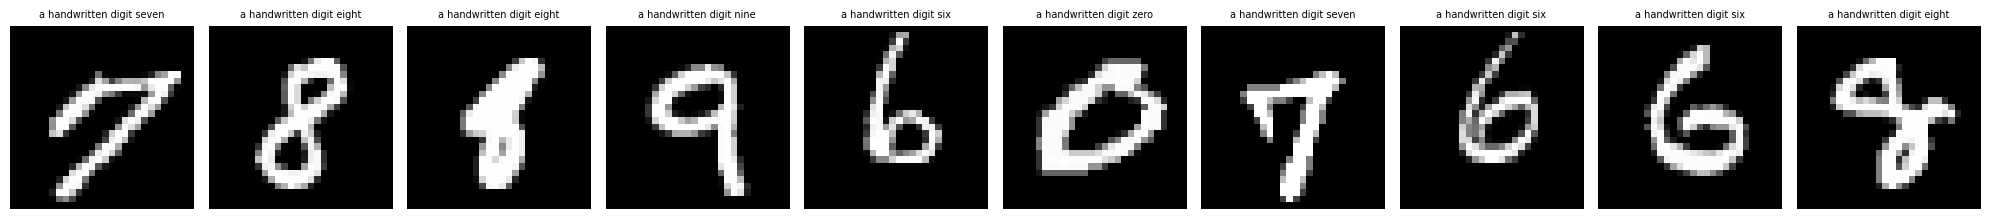

In [ ]:
# train_loader, test_loader, train_dataset, test_dataset = get_mnist_text_dataloaders(
#     prompt_type='long', batch_size=64, visualize=True
# )

## Function for training the DDPM and DDIM

In [ ]:
def run_diffusion_pipeline_with_prompt_type(train_dataset, test_dataset,
                                            prompt_type='long',
                                            save_path="best_model.pt",
                                            method='ddpm',
                                            ddim_steps=50,
                                            eta=0.0,
                                            epochs=1,
                                            patience=3,
                                            min_delta=1e-4,
                                            measure_time=True,
                                            visualize=True,
                                            device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # === Prompt function selector ===
    prompt_map = {
        'numeric': numeric_prompt,
        'digit': digit_prompt,
        'long': long_prompt
    }

    assert prompt_type in prompt_map, f"Invalid prompt_type '{prompt_type}'. Choose from: {list(prompt_map.keys())}"
    assert method in ['ddpm', 'ddim'], f"Invalid method '{method}'. Choose 'ddpm' or 'ddim'"

    prompt_fn = prompt_map[prompt_type]
    prompts = [prompt_fn(i) for i in range(10)]

    # === Model ===
    model = DiffusionModel(device=device)
    model.load_text_conditioned_data(train_dataset, test_dataset)

    # === Training ===
    model.train(epochs=epochs, patience=patience, min_delta=min_delta, save_path=save_path)
    model.load_model(save_path)

    # === Sampling ===
    if method == 'ddpm':
        samples = model.generate_samples(
            prompts, name=f"samples_{prompt_type}_ddpm", use_ddim=False
        )
    else:
        samples = model.generate_samples(
            prompts, name=f"samples_{prompt_type}_ddim", use_ddim=True,
            ddim_steps=ddim_steps, eta=eta
        )

    # === Visualization ===
    if visualize:
        model.visualize_samples(samples, prompts)

    # === Timing ===
    if measure_time:
        start_time = time.time()
        _ = model.sample(
            num_samples=len(prompts), text_prompts=prompts,
            use_ddim=(method == 'ddim'), ddim_steps=ddim_steps, eta=eta
        )
        elapsed = time.time() - start_time
        print(f"Sampling time ({method.upper()}, prompt='{prompt_type}'): {elapsed:.2f} seconds")

    return model

# DDPM

## DDPM long prompts

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Sample visualization for prompt_type = 'long'


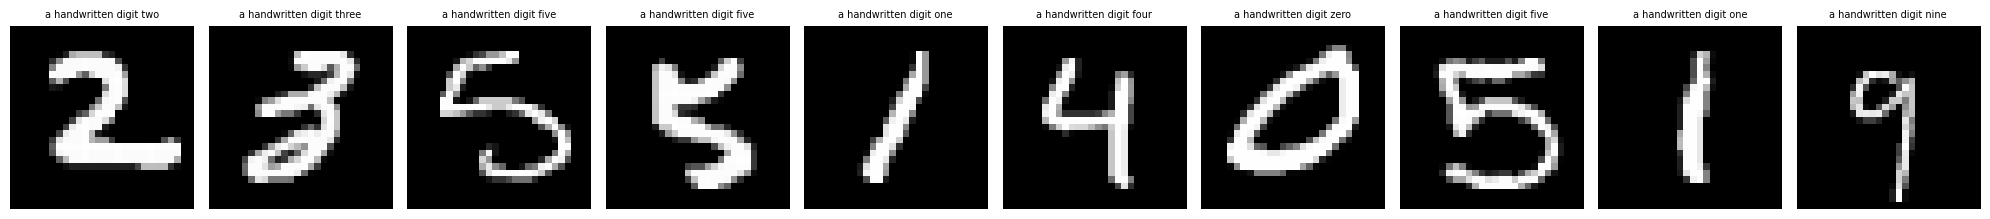

In [ ]:
prompt_type_long = 'long'

# Load data loaders and datasets for the current prompt type
train_loader_long, test_loader_long, train_dataset_long, test_dataset_long = get_mnist_text_dataloaders(
    prompt_type=prompt_type_long,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [01:21<1:06:30, 81.44s/it]

Epoch 1, Train Loss: 0.0885, Test Loss: 0.0618, Time: 1.36 min
Saved best model at epoch 1 with test loss: 0.0618


Training Epochs:   4%|▍         | 2/50 [02:32<1:00:24, 75.50s/it]

Epoch 2, Train Loss: 0.0560, Test Loss: 0.0515, Time: 1.19 min
Saved best model at epoch 2 with test loss: 0.0515


Training Epochs:   6%|▌         | 3/50 [03:42<57:00, 72.79s/it]  

Epoch 3, Train Loss: 0.0483, Test Loss: 0.0449, Time: 1.16 min
Saved best model at epoch 3 with test loss: 0.0449


Training Epochs:   8%|▊         | 4/50 [04:50<54:32, 71.14s/it]

Epoch 4, Train Loss: 0.0452, Test Loss: 0.0421, Time: 1.14 min
Saved best model at epoch 4 with test loss: 0.0421


Training Epochs:  10%|█         | 5/50 [05:59<52:41, 70.26s/it]

Epoch 5, Train Loss: 0.0451, Test Loss: 0.0457, Time: 1.14 min
No improvement. Patience counter: 1/3


Training Epochs:  12%|█▏        | 6/50 [07:13<52:31, 71.63s/it]

Epoch 6, Train Loss: 0.0410, Test Loss: 0.0382, Time: 1.24 min
Saved best model at epoch 6 with test loss: 0.0382


Training Epochs:  14%|█▍        | 7/50 [08:29<52:17, 72.96s/it]

Epoch 7, Train Loss: 0.0390, Test Loss: 0.0390, Time: 1.26 min
No improvement. Patience counter: 1/3


Training Epochs:  16%|█▌        | 8/50 [09:38<50:04, 71.54s/it]

Epoch 8, Train Loss: 0.0374, Test Loss: 0.0379, Time: 1.14 min
Saved best model at epoch 8 with test loss: 0.0379


Training Epochs:  18%|█▊        | 9/50 [10:49<48:56, 71.61s/it]

Epoch 9, Train Loss: 0.0357, Test Loss: 0.0363, Time: 1.20 min
Saved best model at epoch 9 with test loss: 0.0363


Training Epochs:  20%|██        | 10/50 [11:59<47:20, 71.02s/it]

Epoch 10, Train Loss: 0.0371, Test Loss: 0.0348, Time: 1.16 min
Saved best model at epoch 10 with test loss: 0.0348


Training Epochs:  22%|██▏       | 11/50 [13:08<45:41, 70.30s/it]

Epoch 11, Train Loss: 0.0342, Test Loss: 0.0341, Time: 1.14 min
Saved best model at epoch 11 with test loss: 0.0341


Training Epochs:  24%|██▍       | 12/50 [14:20<44:59, 71.04s/it]

Epoch 12, Train Loss: 0.0337, Test Loss: 0.0324, Time: 1.21 min
Saved best model at epoch 12 with test loss: 0.0324


Training Epochs:  26%|██▌       | 13/50 [15:34<44:14, 71.73s/it]

Epoch 13, Train Loss: 0.0332, Test Loss: 0.0312, Time: 1.22 min
Saved best model at epoch 13 with test loss: 0.0312


Training Epochs:  28%|██▊       | 14/50 [16:43<42:34, 70.95s/it]

Epoch 14, Train Loss: 0.0321, Test Loss: 0.0316, Time: 1.15 min
No improvement. Patience counter: 1/3


Training Epochs:  30%|███       | 15/50 [17:59<42:11, 72.34s/it]

Epoch 15, Train Loss: 0.0320, Test Loss: 0.0317, Time: 1.26 min
No improvement. Patience counter: 2/3


Training Epochs:  32%|███▏      | 16/50 [19:09<40:43, 71.85s/it]

Epoch 16, Train Loss: 0.0307, Test Loss: 0.0300, Time: 1.18 min
Saved best model at epoch 16 with test loss: 0.0300


Training Epochs:  34%|███▍      | 17/50 [20:23<39:48, 72.38s/it]

Epoch 17, Train Loss: 0.0312, Test Loss: 0.0290, Time: 1.23 min
Saved best model at epoch 17 with test loss: 0.0290


Training Epochs:  36%|███▌      | 18/50 [21:32<38:02, 71.33s/it]

Epoch 18, Train Loss: 0.0304, Test Loss: 0.0304, Time: 1.15 min
No improvement. Patience counter: 1/3


Training Epochs:  38%|███▊      | 19/50 [22:41<36:28, 70.60s/it]

Epoch 19, Train Loss: 0.0301, Test Loss: 0.0346, Time: 1.15 min
No improvement. Patience counter: 2/3


Training Epochs:  38%|███▊      | 19/50 [23:49<38:52, 75.23s/it]

Epoch 20, Train Loss: 0.0297, Test Loss: 0.0290, Time: 1.14 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 23.82 minutes


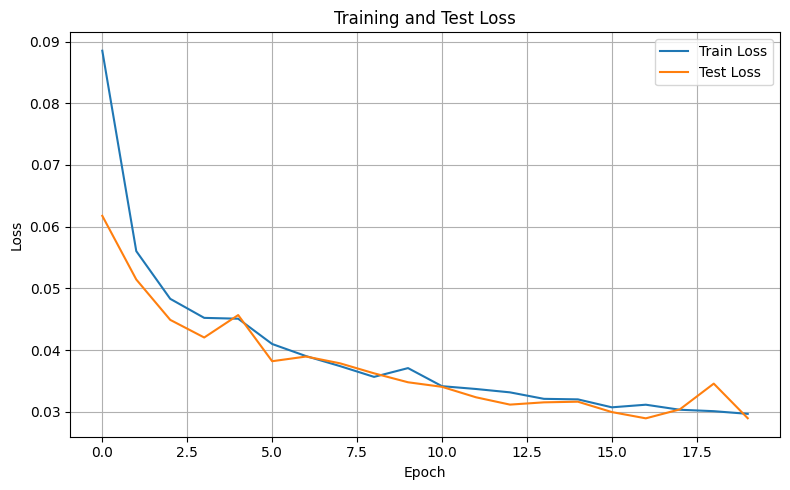

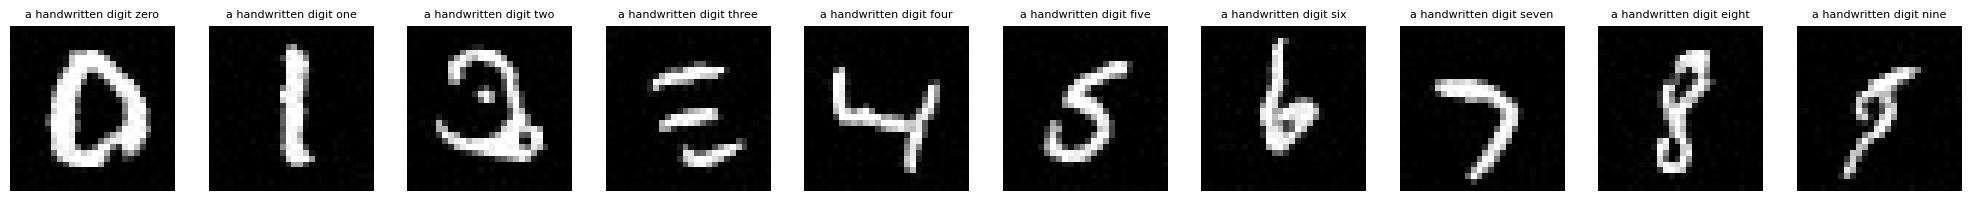

Sampling time (DDPM, prompt='long'): 2.63 seconds


In [ ]:
# Define path to save the trained model
save_path_ddpm_long = f"ddpm_{prompt_type_long}.pt"

# Run the training and sampling pipeline
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_long,
    test_dataset=test_dataset_long,
    prompt_type=prompt_type_long,
    save_path=save_path_ddpm_long,
    method='ddpm',
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
from google.colab import files
files.download("ddpm_long.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ddpm_long_model = DiffusionModel(device=device)
ddpm_long_model.load_model("ddpm_long.pt")
ddpm_long_model.load_text_conditioned_data(train_dataset_long, test_dataset_long)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
fid_score_long = compute_fid_score(
    ddpm_long_model,
    num_samples=1000,
    use_ddim=False
)
# print(f"FID Score (DDPM, long prompts): {fid_score_long:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 160MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|█

FID (use_ddim=False): 171.0390
FID Score (DDPM, long prompts): 171.0390


In [ ]:
is_score_long = compute_inception_score(
    ddpm_long_model,
    num_samples=1000,
    use_ddim=False
)
# print(f"IS Score (DDPM, long prompts): {is_score_long_mean:.4f} ± {is_score_long_std:.4f}")

Inception Score (use_ddim=False): 1.4758 ± 0.0410


TypeError: unsupported format string passed to tuple.__format__

In [ ]:
prdc_scores_long = compute_prdc_score(
    ddpm_long_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=False,
    ddim_steps=50,
    eta=0.0
)
# print(f"PRDC (DDPM, long prompts): {prdc_scores_long:.4f}")

PRDC (use_ddim=False):
precision: 0.0330
recall: 0.0570
density: 0.0192
coverage: 0.0330


TypeError: unsupported format string passed to dict.__format__

In [ ]:
clip_score_long = compute_clip_score_for_prompt_type(
    model=ddpm_long_model,
    prompt_type='long',
    samples_per_prompt=5,
    use_ddim=False
)
# print(f"CLIP Score (DDPM, long prompts): {clip_score_long:.4f}")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


📌 Evaluating CLIP score for prompt type: 'long' (use_ddim=False)
CLIP Score for 'long': 23.9863


## DDPM digit prompts

Sample visualization for prompt_type = 'digit'


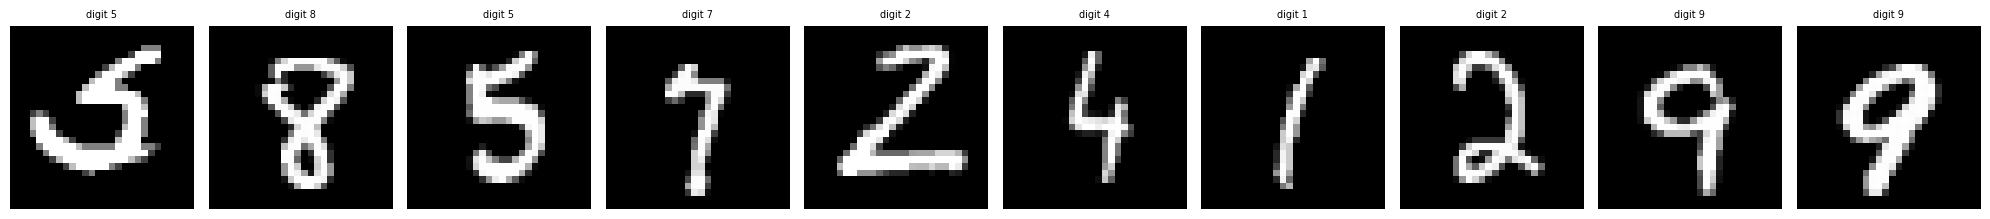

In [ ]:
prompt_type_digit = 'digit'

# Load data loaders and datasets for the current prompt type
train_loader_digit, test_loader_digit, train_dataset_digit, test_dataset_digit = get_mnist_text_dataloaders(
    prompt_type=prompt_type_digit,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [00:58<47:30, 58.18s/it]

Epoch 1, Train Loss: 0.0905, Test Loss: 0.0647, Time: 0.97 min
Saved best model at epoch 1 with test loss: 0.0647


Training Epochs:   4%|▍         | 2/50 [01:55<46:18, 57.89s/it]

Epoch 2, Train Loss: 0.0581, Test Loss: 0.0534, Time: 0.96 min
Saved best model at epoch 2 with test loss: 0.0534


Training Epochs:   6%|▌         | 3/50 [02:54<45:36, 58.21s/it]

Epoch 3, Train Loss: 0.0499, Test Loss: 0.0493, Time: 0.98 min
Saved best model at epoch 3 with test loss: 0.0493


Training Epochs:   8%|▊         | 4/50 [03:51<44:10, 57.63s/it]

Epoch 4, Train Loss: 0.0456, Test Loss: 0.0412, Time: 0.94 min
Saved best model at epoch 4 with test loss: 0.0412


Training Epochs:  10%|█         | 5/50 [04:48<43:13, 57.64s/it]

Epoch 5, Train Loss: 0.0415, Test Loss: 0.0447, Time: 0.96 min
No improvement. Patience counter: 1/3


Training Epochs:  12%|█▏        | 6/50 [05:45<42:07, 57.45s/it]

Epoch 6, Train Loss: 0.0396, Test Loss: 0.0370, Time: 0.95 min
Saved best model at epoch 6 with test loss: 0.0370


Training Epochs:  14%|█▍        | 7/50 [06:43<41:08, 57.42s/it]

Epoch 7, Train Loss: 0.0422, Test Loss: 0.0363, Time: 0.96 min
Saved best model at epoch 7 with test loss: 0.0363


Training Epochs:  16%|█▌        | 8/50 [07:41<40:22, 57.68s/it]

Epoch 8, Train Loss: 0.0370, Test Loss: 0.0346, Time: 0.97 min
Saved best model at epoch 8 with test loss: 0.0346


Training Epochs:  18%|█▊        | 9/50 [08:38<39:16, 57.47s/it]

Epoch 9, Train Loss: 0.0356, Test Loss: 0.0349, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  20%|██        | 10/50 [09:36<38:26, 57.67s/it]

Epoch 10, Train Loss: 0.0348, Test Loss: 0.0331, Time: 0.97 min
Saved best model at epoch 10 with test loss: 0.0331


Training Epochs:  22%|██▏       | 11/50 [10:33<37:23, 57.52s/it]

Epoch 11, Train Loss: 0.0340, Test Loss: 0.0312, Time: 0.95 min
Saved best model at epoch 11 with test loss: 0.0312


Training Epochs:  24%|██▍       | 12/50 [11:31<36:22, 57.42s/it]

Epoch 12, Train Loss: 0.0332, Test Loss: 0.0332, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  26%|██▌       | 13/50 [12:29<35:32, 57.63s/it]

Epoch 13, Train Loss: 0.0330, Test Loss: 0.0314, Time: 0.97 min
No improvement. Patience counter: 2/3


Training Epochs:  28%|██▊       | 14/50 [13:25<34:23, 57.31s/it]

Epoch 14, Train Loss: 0.0320, Test Loss: 0.0302, Time: 0.94 min
Saved best model at epoch 14 with test loss: 0.0302


Training Epochs:  30%|███       | 15/50 [14:23<33:29, 57.42s/it]

Epoch 15, Train Loss: 0.0314, Test Loss: 0.0312, Time: 0.96 min
No improvement. Patience counter: 1/3


Training Epochs:  32%|███▏      | 16/50 [15:20<32:31, 57.41s/it]

Epoch 16, Train Loss: 0.0311, Test Loss: 0.0307, Time: 0.96 min
No improvement. Patience counter: 2/3


Training Epochs:  34%|███▍      | 17/50 [16:18<31:38, 57.53s/it]

Epoch 17, Train Loss: 0.0303, Test Loss: 0.0288, Time: 0.96 min
Saved best model at epoch 17 with test loss: 0.0288


Training Epochs:  36%|███▌      | 18/50 [17:15<30:36, 57.39s/it]

Epoch 18, Train Loss: 0.0305, Test Loss: 0.0295, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  38%|███▊      | 19/50 [18:11<29:25, 56.95s/it]

Epoch 19, Train Loss: 0.0295, Test Loss: 0.0286, Time: 0.93 min
Saved best model at epoch 19 with test loss: 0.0286


Training Epochs:  40%|████      | 20/50 [19:08<28:26, 56.88s/it]

Epoch 20, Train Loss: 0.0294, Test Loss: 0.0296, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  42%|████▏     | 21/50 [20:04<27:20, 56.56s/it]

Epoch 21, Train Loss: 0.0289, Test Loss: 0.0292, Time: 0.93 min
No improvement. Patience counter: 2/3


Training Epochs:  42%|████▏     | 21/50 [21:01<29:01, 60.06s/it]

Epoch 22, Train Loss: 0.0292, Test Loss: 0.0329, Time: 0.95 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 21.02 minutes


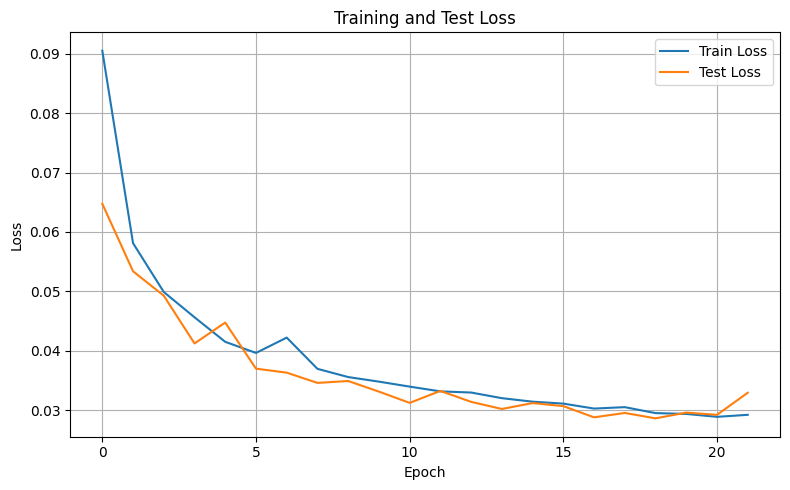

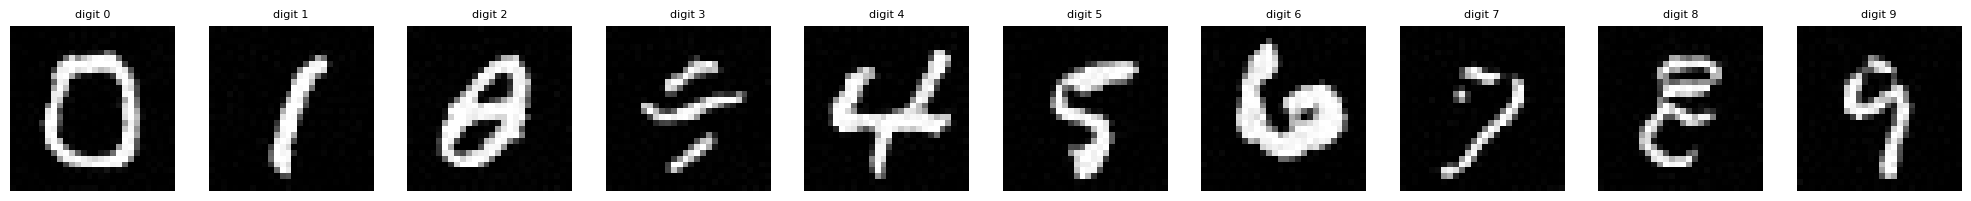

Sampling time (DDPM, prompt='digit'): 2.59 seconds


In [ ]:
# Define path to save the trained model
save_path_ddpm_digit = f"ddpm_{prompt_type_digit}.pt"

# Run the training and sampling pipeline
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_digit,
    test_dataset=test_dataset_digit,
    prompt_type=prompt_type_digit,
    save_path=save_path_ddpm_digit,
    method='ddpm',
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
from google.colab import files
files.download("ddpm_digit.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ddpm_digit_model = DiffusionModel(device=device)
ddpm_digit_model.load_model("ddpm_digit.pt")
ddpm_digit_model.load_text_conditioned_data(train_dataset_digit, test_dataset_digit)

In [ ]:
fid_score_digit = compute_fid_score(
    ddpm_digit_model,
    num_samples=1000,
    use_ddim=False
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID (use_ddim=False): 108.3315


In [ ]:
is_score_digit = compute_inception_score(
    ddpm_digit_model,
    num_samples=1000,
    use_ddim=False
)

Inception Score (use_ddim=False): 1.7410 ± 0.0667


In [ ]:
prdc_scores_digit = compute_prdc_score(
    ddpm_digit_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=False,
    ddim_steps=50,
    eta=0.0
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PRDC (use_ddim=False):
precision: 0.2370
recall: 0.1490
density: 0.1550
coverage: 0.2370


In [ ]:
clip_score_digit = compute_clip_score_for_prompt_type(
    model=ddpm_digit_model,
    prompt_type='digit',
    samples_per_prompt=5,
    use_ddim=False
)


📌 Evaluating CLIP score for prompt type: 'digit' (use_ddim=False)
CLIP Score for 'digit': 24.4259


## DDPM numeric prompts

Sample visualization for prompt_type = 'numeric'


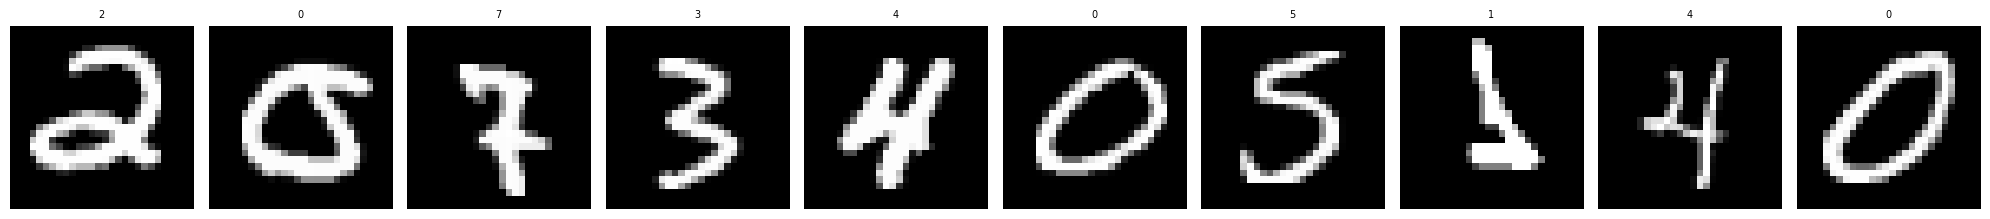

In [ ]:
prompt_type_numeric = 'numeric'

# Load data loaders and datasets for the current prompt type
train_loader_numeric, test_loader_numeric, train_dataset_numeric, test_dataset_numeric = get_mnist_text_dataloaders(
    prompt_type=prompt_type_numeric,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [00:58<47:52, 58.62s/it]

Epoch 1, Train Loss: 0.0968, Test Loss: 0.0641, Time: 0.98 min
Saved best model at epoch 1 with test loss: 0.0641


Training Epochs:   4%|▍         | 2/50 [01:53<45:03, 56.32s/it]

Epoch 2, Train Loss: 0.0582, Test Loss: 0.0597, Time: 0.91 min
Saved best model at epoch 2 with test loss: 0.0597


Training Epochs:   6%|▌         | 3/50 [02:48<43:34, 55.63s/it]

Epoch 3, Train Loss: 0.0508, Test Loss: 0.0502, Time: 0.91 min
Saved best model at epoch 3 with test loss: 0.0502


Training Epochs:   8%|▊         | 4/50 [03:42<42:10, 55.02s/it]

Epoch 4, Train Loss: 0.0462, Test Loss: 0.0474, Time: 0.90 min
Saved best model at epoch 4 with test loss: 0.0474


Training Epochs:  10%|█         | 5/50 [04:37<41:12, 54.93s/it]

Epoch 5, Train Loss: 0.0432, Test Loss: 0.0447, Time: 0.91 min
Saved best model at epoch 5 with test loss: 0.0447


Training Epochs:  12%|█▏        | 6/50 [05:31<40:09, 54.76s/it]

Epoch 6, Train Loss: 0.0436, Test Loss: 0.0433, Time: 0.91 min
Saved best model at epoch 6 with test loss: 0.0433


Training Epochs:  14%|█▍        | 7/50 [06:27<39:32, 55.17s/it]

Epoch 7, Train Loss: 0.0413, Test Loss: 0.0378, Time: 0.93 min
Saved best model at epoch 7 with test loss: 0.0378


Training Epochs:  16%|█▌        | 8/50 [07:24<39:05, 55.85s/it]

Epoch 8, Train Loss: 0.0391, Test Loss: 0.0366, Time: 0.95 min
Saved best model at epoch 8 with test loss: 0.0366


Training Epochs:  18%|█▊        | 9/50 [08:23<38:44, 56.69s/it]

Epoch 9, Train Loss: 0.0376, Test Loss: 0.0366, Time: 0.98 min
No improvement. Patience counter: 1/3


Training Epochs:  20%|██        | 10/50 [09:21<38:02, 57.05s/it]

Epoch 10, Train Loss: 0.0362, Test Loss: 0.0342, Time: 0.96 min
Saved best model at epoch 10 with test loss: 0.0342


Training Epochs:  22%|██▏       | 11/50 [10:16<36:45, 56.54s/it]

Epoch 11, Train Loss: 0.0356, Test Loss: 0.0332, Time: 0.92 min
Saved best model at epoch 11 with test loss: 0.0332


Training Epochs:  24%|██▍       | 12/50 [11:10<35:17, 55.73s/it]

Epoch 12, Train Loss: 0.0347, Test Loss: 0.0338, Time: 0.90 min
No improvement. Patience counter: 1/3


Training Epochs:  26%|██▌       | 13/50 [12:03<33:57, 55.07s/it]

Epoch 13, Train Loss: 0.0335, Test Loss: 0.0325, Time: 0.89 min
Saved best model at epoch 13 with test loss: 0.0325


Training Epochs:  28%|██▊       | 14/50 [12:57<32:50, 54.74s/it]

Epoch 14, Train Loss: 0.0330, Test Loss: 0.0330, Time: 0.90 min
No improvement. Patience counter: 1/3


Training Epochs:  30%|███       | 15/50 [14:01<33:25, 57.30s/it]

Epoch 15, Train Loss: 0.0325, Test Loss: 0.0299, Time: 1.05 min
Saved best model at epoch 15 with test loss: 0.0299


Training Epochs:  32%|███▏      | 16/50 [14:57<32:18, 57.03s/it]

Epoch 16, Train Loss: 0.0318, Test Loss: 0.0330, Time: 0.94 min
No improvement. Patience counter: 1/3


Training Epochs:  34%|███▍      | 17/50 [15:57<31:46, 57.76s/it]

Epoch 17, Train Loss: 0.0316, Test Loss: 0.0321, Time: 0.99 min
No improvement. Patience counter: 2/3


Training Epochs:  34%|███▍      | 17/50 [16:53<32:46, 59.60s/it]

Epoch 18, Train Loss: 0.0308, Test Loss: 0.0300, Time: 0.94 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 16.89 minutes


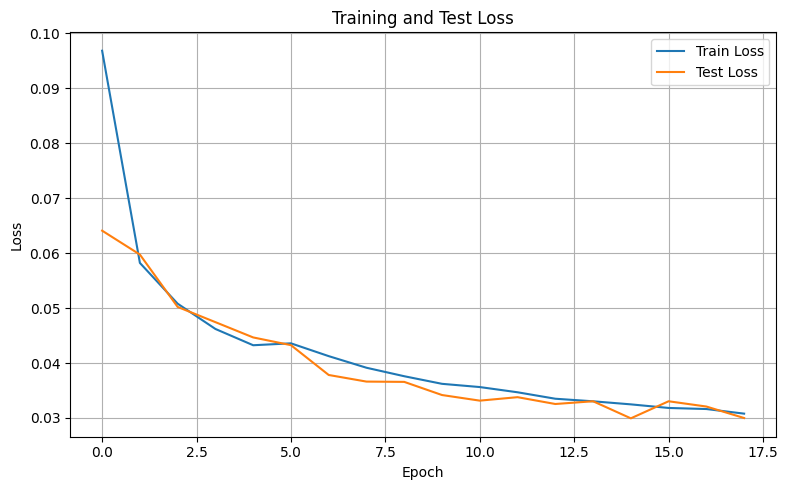

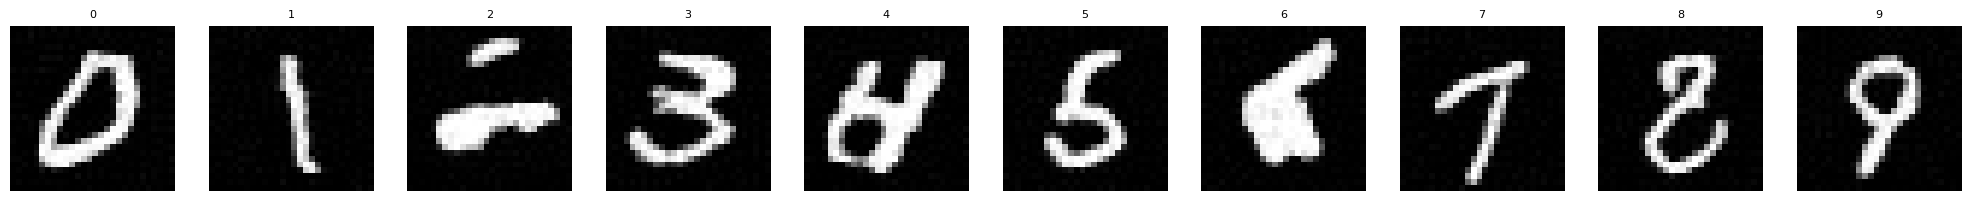

Sampling time (DDPM, prompt='numeric'): 2.99 seconds


In [ ]:
# Define path to save the trained model
save_path_ddpm_numeric = f"ddpm_{prompt_type_numeric}.pt"

# Run the training and sampling pipeline
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_numeric,
    test_dataset=test_dataset_numeric,
    prompt_type=prompt_type_numeric,
    save_path=save_path_ddpm_numeric,
    method='ddpm',
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
from google.colab import files
files.download("ddpm_numeric.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ddpm_numeric_model = DiffusionModel(device=device)
ddpm_numeric_model.load_model("ddpm_numeric.pt")
ddpm_numeric_model.load_text_conditioned_data(train_dataset_numeric, test_dataset_numeric)

In [ ]:
fid_score_numeric = compute_fid_score(
    ddpm_numeric_model,
    num_samples=1000,
    use_ddim=False
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID (use_ddim=False): 139.4723


In [ ]:
is_score_numeric = compute_inception_score(
    ddpm_numeric_model,
    num_samples=1000,
    use_ddim=False
)

Inception Score (use_ddim=False): 1.5623 ± 0.0651


In [ ]:
prdc_scores_numeric = compute_prdc_score(
    ddpm_numeric_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=False,
    ddim_steps=50,
    eta=0.0
)

PRDC (use_ddim=False):
precision: 0.1950
recall: 0.0180
density: 0.1274
coverage: 0.1950


In [ ]:
clip_score_numeric = compute_clip_score_for_prompt_type(
    model=ddpm_numeric_model,
    prompt_type='numeric',
    samples_per_prompt=5,
    use_ddim=False
)


📌 Evaluating CLIP score for prompt type: 'numeric' (use_ddim=False)
CLIP Score for 'numeric': 23.4325


# DDIM

## DDIM long prompts

Sample visualization for prompt_type = 'long'


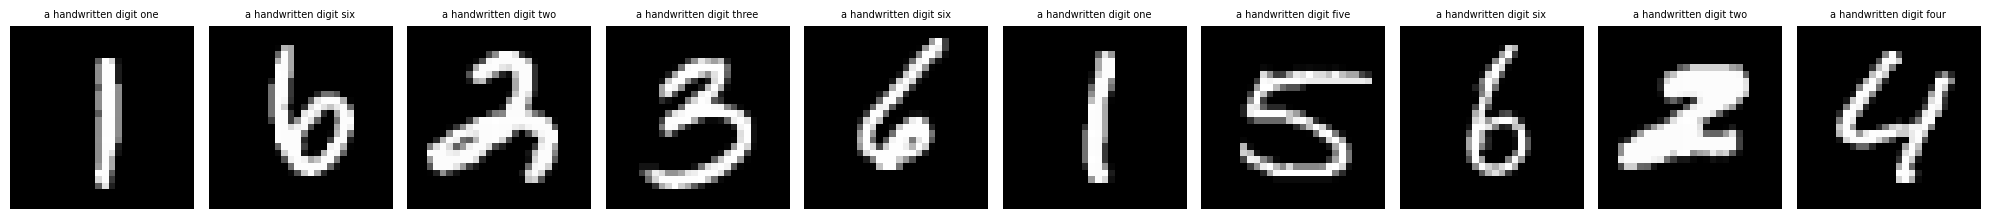

In [ ]:
prompt_type_ddim_long = 'long'

# Load dataset for the prompt
train_loader_ddim_long, test_loader_ddim_long, train_dataset_ddim_long, test_dataset_ddim_long = get_mnist_text_dataloaders(
    prompt_type=prompt_type_ddim_long,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [01:12<59:34, 72.96s/it]

Epoch 1, Train Loss: 0.0903, Test Loss: 0.0605, Time: 1.22 min
Saved best model at epoch 1 with test loss: 0.0605


Training Epochs:   4%|▍         | 2/50 [02:21<56:05, 70.11s/it]

Epoch 2, Train Loss: 0.0565, Test Loss: 0.0510, Time: 1.13 min
Saved best model at epoch 2 with test loss: 0.0510


Training Epochs:   6%|▌         | 3/50 [03:30<54:33, 69.65s/it]

Epoch 3, Train Loss: 0.0483, Test Loss: 0.0509, Time: 1.15 min
Saved best model at epoch 3 with test loss: 0.0509


Training Epochs:   8%|▊         | 4/50 [04:38<52:57, 69.07s/it]

Epoch 4, Train Loss: 0.0447, Test Loss: 0.0410, Time: 1.14 min
Saved best model at epoch 4 with test loss: 0.0410


Training Epochs:  10%|█         | 5/50 [05:47<51:46, 69.03s/it]

Epoch 5, Train Loss: 0.0417, Test Loss: 0.0395, Time: 1.15 min
Saved best model at epoch 5 with test loss: 0.0395


Training Epochs:  12%|█▏        | 6/50 [06:55<50:19, 68.62s/it]

Epoch 6, Train Loss: 0.0399, Test Loss: 0.0672, Time: 1.13 min
No improvement. Patience counter: 1/3


Training Epochs:  14%|█▍        | 7/50 [08:03<49:07, 68.54s/it]

Epoch 7, Train Loss: 0.0398, Test Loss: 0.0403, Time: 1.14 min
No improvement. Patience counter: 2/3


Training Epochs:  16%|█▌        | 8/50 [09:11<47:47, 68.26s/it]

Epoch 8, Train Loss: 0.0374, Test Loss: 0.0367, Time: 1.13 min
Saved best model at epoch 8 with test loss: 0.0367


Training Epochs:  18%|█▊        | 9/50 [10:19<46:38, 68.25s/it]

Epoch 9, Train Loss: 0.0351, Test Loss: 0.0352, Time: 1.14 min
Saved best model at epoch 9 with test loss: 0.0352


Training Epochs:  20%|██        | 10/50 [11:27<45:26, 68.16s/it]

Epoch 10, Train Loss: 0.0342, Test Loss: 0.0334, Time: 1.13 min
Saved best model at epoch 10 with test loss: 0.0334


Training Epochs:  22%|██▏       | 11/50 [12:35<44:14, 68.07s/it]

Epoch 11, Train Loss: 0.0341, Test Loss: 0.0336, Time: 1.13 min
No improvement. Patience counter: 1/3


Training Epochs:  24%|██▍       | 12/50 [13:43<43:05, 68.05s/it]

Epoch 12, Train Loss: 0.0327, Test Loss: 0.0332, Time: 1.13 min
Saved best model at epoch 12 with test loss: 0.0332


Training Epochs:  26%|██▌       | 13/50 [14:50<41:53, 67.93s/it]

Epoch 13, Train Loss: 0.0321, Test Loss: 0.0316, Time: 1.13 min
Saved best model at epoch 13 with test loss: 0.0316


Training Epochs:  28%|██▊       | 14/50 [15:59<40:49, 68.05s/it]

Epoch 14, Train Loss: 0.0316, Test Loss: 0.0312, Time: 1.14 min
Saved best model at epoch 14 with test loss: 0.0312


Training Epochs:  30%|███       | 15/50 [17:06<39:34, 67.85s/it]

Epoch 15, Train Loss: 0.0317, Test Loss: 0.0302, Time: 1.12 min
Saved best model at epoch 15 with test loss: 0.0302


Training Epochs:  32%|███▏      | 16/50 [18:14<38:29, 67.92s/it]

Epoch 16, Train Loss: 0.0309, Test Loss: 0.0305, Time: 1.13 min
No improvement. Patience counter: 1/3


Training Epochs:  34%|███▍      | 17/50 [19:21<37:14, 67.70s/it]

Epoch 17, Train Loss: 0.0306, Test Loss: 0.0290, Time: 1.12 min
Saved best model at epoch 17 with test loss: 0.0290


Training Epochs:  36%|███▌      | 18/50 [20:30<36:14, 67.95s/it]

Epoch 18, Train Loss: 0.0304, Test Loss: 0.0300, Time: 1.14 min
No improvement. Patience counter: 1/3


Training Epochs:  38%|███▊      | 19/50 [21:37<35:00, 67.76s/it]

Epoch 19, Train Loss: 0.0298, Test Loss: 0.0294, Time: 1.12 min
No improvement. Patience counter: 2/3


Training Epochs:  38%|███▊      | 19/50 [22:45<37:08, 71.88s/it]

Epoch 20, Train Loss: 0.0307, Test Loss: 0.0294, Time: 1.13 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 22.76 minutes


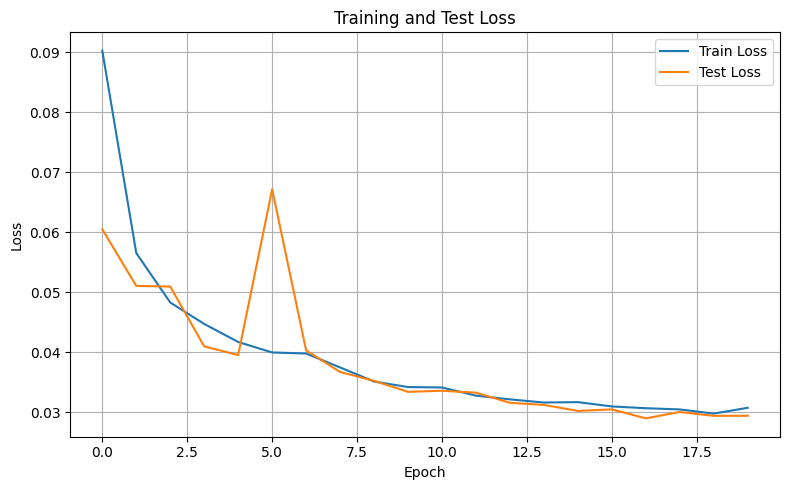

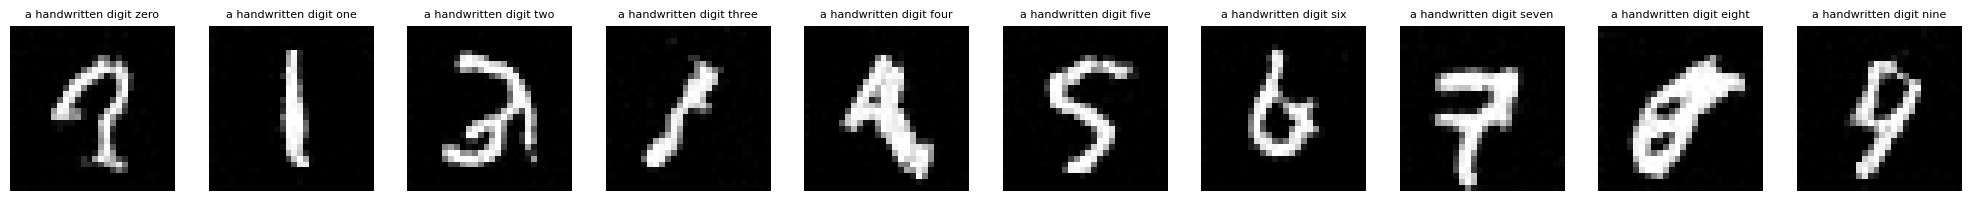

Sampling time (DDIM, prompt='long'): 0.15 seconds


In [ ]:
save_path = f"ddim_{prompt_type_ddim_long}.pt"

# Run training & sampling with DDIM
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_ddim_long,
    test_dataset=test_dataset_ddim_long,
    prompt_type=prompt_type_ddim_long,
    save_path=save_path,
    method='ddim',
    ddim_steps=50,
    eta=0.0,
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
ddim_long_model = DiffusionModel(device=device)
ddim_long_model.load_model("ddim_long.pt")  # use your trained DDIM model checkpoint
ddim_long_model.load_text_conditioned_data(train_dataset_ddim_long, test_dataset_ddim_long)

In [ ]:
fid_score_ddim_long = compute_fid_score(
    ddim_long_model,
    num_samples=1000,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID (use_ddim=True): 187.7883


In [ ]:
is_score_ddim_long_mean, is_score_ddim_long_std = compute_inception_score(
    ddim_long_model,
    num_samples=1000,
    use_ddim=True
)

Inception Score (use_ddim=True): 1.3699 ± 0.0247


In [ ]:
prdc_scores_ddim_long = compute_prdc_score(
    ddim_long_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

PRDC (use_ddim=True):
precision: 0.0210
recall: 0.0030
density: 0.0156
coverage: 0.0210


In [ ]:
clip_score_ddim_long = compute_clip_score_for_prompt_type(
    model=ddim_long_model,
    prompt_type='long',
    samples_per_prompt=5,
    use_ddim=True
)


📌 Evaluating CLIP score for prompt type: 'long' (use_ddim=True)
CLIP Score for 'long': 25.3601


## DDIM digit prompts

Sample visualization for prompt_type = 'digit'


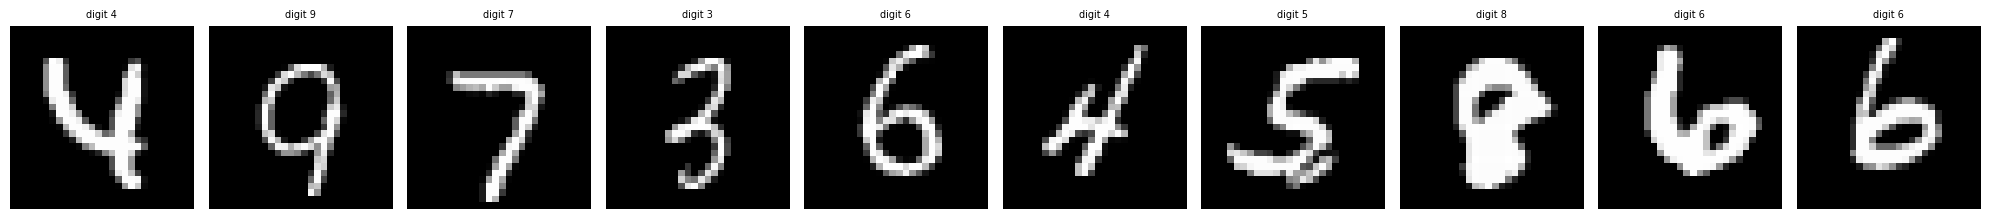

In [ ]:
prompt_type_ddim_digit = 'digit'

# Load dataset for the prompt
train_loader_ddim_digit, test_loader_ddim_digit, train_dataset_ddim_digit, test_dataset_ddim_digit = get_mnist_text_dataloaders(
    prompt_type=prompt_type_ddim_digit,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [00:58<47:31, 58.19s/it]

Epoch 1, Train Loss: 0.0910, Test Loss: 0.0601, Time: 0.97 min
Saved best model at epoch 1 with test loss: 0.0601


Training Epochs:   4%|▍         | 2/50 [01:55<45:59, 57.50s/it]

Epoch 2, Train Loss: 0.0572, Test Loss: 0.0559, Time: 0.95 min
Saved best model at epoch 2 with test loss: 0.0559


Training Epochs:   6%|▌         | 3/50 [02:51<44:35, 56.94s/it]

Epoch 3, Train Loss: 0.0493, Test Loss: 0.0476, Time: 0.94 min
Saved best model at epoch 3 with test loss: 0.0476


Training Epochs:   8%|▊         | 4/50 [03:49<43:52, 57.22s/it]

Epoch 4, Train Loss: 0.0453, Test Loss: 0.0413, Time: 0.96 min
Saved best model at epoch 4 with test loss: 0.0413


Training Epochs:  10%|█         | 5/50 [04:45<42:46, 57.04s/it]

Epoch 5, Train Loss: 0.0425, Test Loss: 0.0408, Time: 0.95 min
Saved best model at epoch 5 with test loss: 0.0408


Training Epochs:  12%|█▏        | 6/50 [05:43<41:58, 57.25s/it]

Epoch 6, Train Loss: 0.0405, Test Loss: 0.0399, Time: 0.96 min
Saved best model at epoch 6 with test loss: 0.0399


Training Epochs:  14%|█▍        | 7/50 [06:40<41:02, 57.26s/it]

Epoch 7, Train Loss: 0.0382, Test Loss: 0.0352, Time: 0.95 min
Saved best model at epoch 7 with test loss: 0.0352


Training Epochs:  16%|█▌        | 8/50 [07:37<40:01, 57.19s/it]

Epoch 8, Train Loss: 0.0365, Test Loss: 0.0359, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  18%|█▊        | 9/50 [08:35<39:06, 57.22s/it]

Epoch 9, Train Loss: 0.0362, Test Loss: 0.0345, Time: 0.95 min
Saved best model at epoch 9 with test loss: 0.0345


Training Epochs:  20%|██        | 10/50 [09:31<38:02, 57.07s/it]

Epoch 10, Train Loss: 0.0349, Test Loss: 0.0322, Time: 0.95 min
Saved best model at epoch 10 with test loss: 0.0322


Training Epochs:  22%|██▏       | 11/50 [10:29<37:16, 57.33s/it]

Epoch 11, Train Loss: 0.0341, Test Loss: 0.0315, Time: 0.96 min
Saved best model at epoch 11 with test loss: 0.0315


Training Epochs:  24%|██▍       | 12/50 [11:26<36:15, 57.26s/it]

Epoch 12, Train Loss: 0.0335, Test Loss: 0.0321, Time: 0.95 min
No improvement. Patience counter: 1/3


Training Epochs:  26%|██▌       | 13/50 [12:23<35:16, 57.20s/it]

Epoch 13, Train Loss: 0.0329, Test Loss: 0.0320, Time: 0.95 min
No improvement. Patience counter: 2/3


Training Epochs:  26%|██▌       | 13/50 [13:21<38:01, 61.65s/it]

Epoch 14, Train Loss: 0.0318, Test Loss: 0.0334, Time: 0.96 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 13.36 minutes


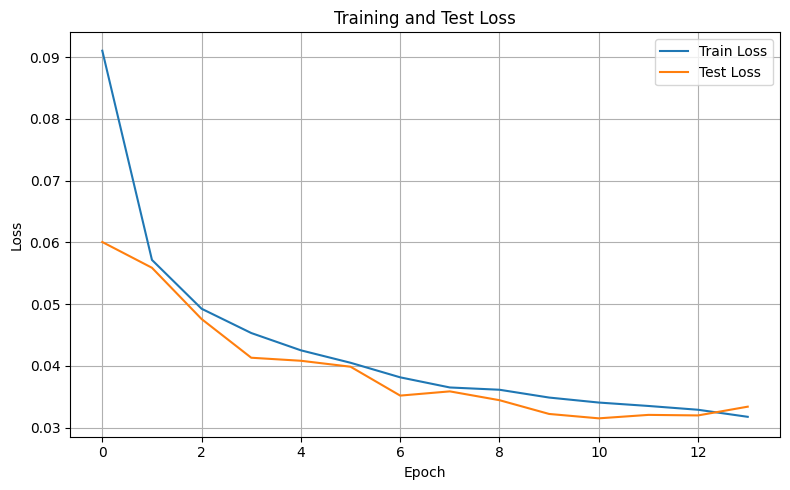

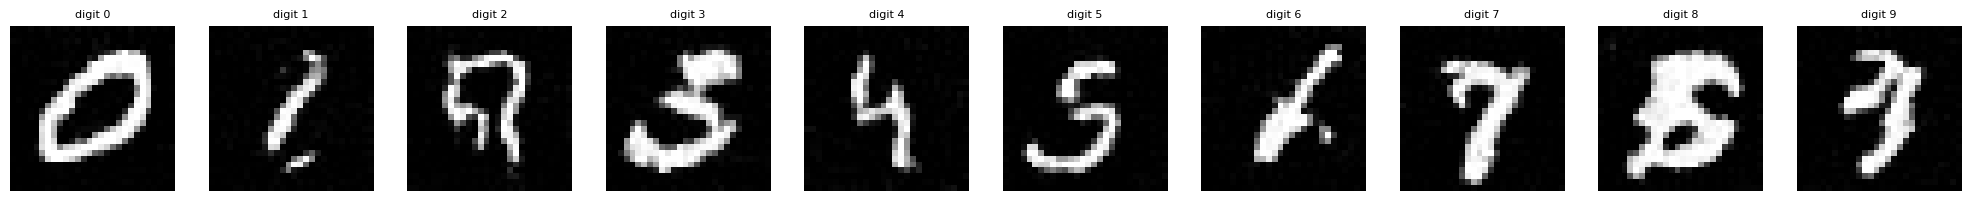

Sampling time (DDIM, prompt='digit'): 0.14 seconds


In [ ]:
save_path_ddim_digit = f"ddim_{prompt_type_ddim_digit}.pt"

# Run training & sampling with DDIM
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_ddim_digit,
    test_dataset=test_dataset_ddim_digit,
    prompt_type=prompt_type_ddim_digit,
    save_path=save_path_ddim_digit,
    method='ddim',
    ddim_steps=50,
    eta=0.0,
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
ddim_digit_model = DiffusionModel(device=device)
ddim_digit_model.load_model("ddim_digit.pt")  # use your trained DDIM model checkpoint
ddim_digit_model.load_text_conditioned_data(train_dataset_ddim_digit, test_dataset_ddim_digit)

In [ ]:
fid_score_ddim_digit = compute_fid_score(
    ddim_digit_model,
    num_samples=1000,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID (use_ddim=True): 122.5455


In [ ]:
is_score_ddim_digit_mean, is_score_ddim_digit_std = compute_inception_score(
    ddim_digit_model,
    num_samples=1000,
    use_ddim=True
)

Inception Score (use_ddim=True): 1.6236 ± 0.0630


In [ ]:
prdc_scores_ddim_digit = compute_prdc_score(
    ddim_digit_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

PRDC (use_ddim=True):
precision: 0.1200
recall: 0.1240
density: 0.0728
coverage: 0.1200


In [ ]:
clip_score_ddim_digit = compute_clip_score_for_prompt_type(
    model=ddim_digit_model,
    prompt_type='digit',
    samples_per_prompt=5,
    use_ddim=True
)


📌 Evaluating CLIP score for prompt type: 'digit' (use_ddim=True)
CLIP Score for 'digit': 23.9114


## DDIM numeric prompts

Sample visualization for prompt_type = 'numeric'


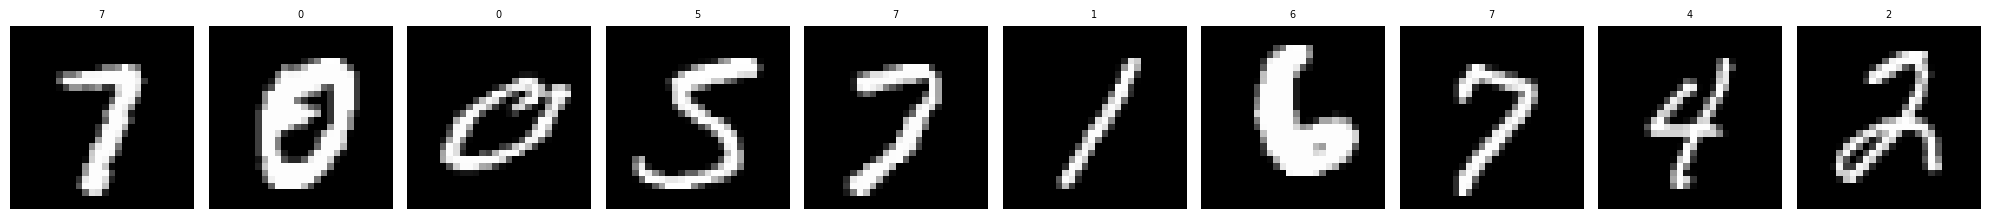

In [ ]:
prompt_type_ddim_numeric = 'numeric'

# Load dataset for the prompt
train_loader_ddim_numeric, test_loader_ddim_numeric, train_dataset_ddim_numeric, test_dataset_ddim_numeric = get_mnist_text_dataloaders(
    prompt_type=prompt_type_ddim_numeric,
    batch_size=64,
    test_size=0.2,
    random_state=42,
    visualize=True
)

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   2%|▏         | 1/50 [00:56<45:44, 56.01s/it]

Epoch 1, Train Loss: 0.0894, Test Loss: 0.0604, Time: 0.93 min
Saved best model at epoch 1 with test loss: 0.0604


Training Epochs:   4%|▍         | 2/50 [01:52<44:48, 56.02s/it]

Epoch 2, Train Loss: 0.0571, Test Loss: 0.0494, Time: 0.93 min
Saved best model at epoch 2 with test loss: 0.0494


Training Epochs:   6%|▌         | 3/50 [02:47<43:34, 55.62s/it]

Epoch 3, Train Loss: 0.0491, Test Loss: 0.0444, Time: 0.92 min
Saved best model at epoch 3 with test loss: 0.0444


Training Epochs:   8%|▊         | 4/50 [03:43<42:45, 55.76s/it]

Epoch 4, Train Loss: 0.0446, Test Loss: 0.0434, Time: 0.93 min
Saved best model at epoch 4 with test loss: 0.0434


Training Epochs:  10%|█         | 5/50 [04:38<41:36, 55.48s/it]

Epoch 5, Train Loss: 0.0428, Test Loss: 0.0409, Time: 0.92 min
Saved best model at epoch 5 with test loss: 0.0409


Training Epochs:  12%|█▏        | 6/50 [05:34<40:51, 55.72s/it]

Epoch 6, Train Loss: 0.0398, Test Loss: 0.0378, Time: 0.94 min
Saved best model at epoch 6 with test loss: 0.0378


Training Epochs:  14%|█▍        | 7/50 [06:29<39:48, 55.56s/it]

Epoch 7, Train Loss: 0.0381, Test Loss: 0.0372, Time: 0.92 min
Saved best model at epoch 7 with test loss: 0.0372


Training Epochs:  16%|█▌        | 8/50 [07:25<39:01, 55.74s/it]

Epoch 8, Train Loss: 0.0366, Test Loss: 0.0360, Time: 0.94 min
Saved best model at epoch 8 with test loss: 0.0360


Training Epochs:  18%|█▊        | 9/50 [08:20<37:58, 55.57s/it]

Epoch 9, Train Loss: 0.0354, Test Loss: 0.0342, Time: 0.92 min
Saved best model at epoch 9 with test loss: 0.0342


Training Epochs:  20%|██        | 10/50 [09:16<37:08, 55.72s/it]

Epoch 10, Train Loss: 0.0341, Test Loss: 0.0330, Time: 0.93 min
Saved best model at epoch 10 with test loss: 0.0330


Training Epochs:  22%|██▏       | 11/50 [10:12<36:09, 55.64s/it]

Epoch 11, Train Loss: 0.0340, Test Loss: 0.0310, Time: 0.92 min
Saved best model at epoch 11 with test loss: 0.0310


Training Epochs:  24%|██▍       | 12/50 [11:07<35:06, 55.43s/it]

Epoch 12, Train Loss: 0.0323, Test Loss: 0.0314, Time: 0.92 min
No improvement. Patience counter: 1/3


Training Epochs:  26%|██▌       | 13/50 [12:02<34:05, 55.30s/it]

Epoch 13, Train Loss: 0.0324, Test Loss: 0.0305, Time: 0.92 min
Saved best model at epoch 13 with test loss: 0.0305


Training Epochs:  28%|██▊       | 14/50 [12:55<32:52, 54.79s/it]

Epoch 14, Train Loss: 0.0314, Test Loss: 0.0303, Time: 0.89 min
Saved best model at epoch 14 with test loss: 0.0303


Training Epochs:  30%|███       | 15/50 [13:50<31:52, 54.64s/it]

Epoch 15, Train Loss: 0.0304, Test Loss: 0.0295, Time: 0.90 min
Saved best model at epoch 15 with test loss: 0.0295


Training Epochs:  32%|███▏      | 16/50 [14:45<31:04, 54.83s/it]

Epoch 16, Train Loss: 0.0307, Test Loss: 0.0296, Time: 0.92 min
No improvement. Patience counter: 1/3


Training Epochs:  34%|███▍      | 17/50 [15:40<30:06, 54.75s/it]

Epoch 17, Train Loss: 0.0299, Test Loss: 0.0307, Time: 0.91 min
No improvement. Patience counter: 2/3


Training Epochs:  36%|███▌      | 18/50 [16:35<29:15, 54.87s/it]

Epoch 18, Train Loss: 0.0295, Test Loss: 0.0280, Time: 0.92 min
Saved best model at epoch 18 with test loss: 0.0280


Training Epochs:  38%|███▊      | 19/50 [17:29<28:15, 54.70s/it]

Epoch 19, Train Loss: 0.0299, Test Loss: 0.0287, Time: 0.90 min
No improvement. Patience counter: 1/3


Training Epochs:  40%|████      | 20/50 [18:23<27:13, 54.45s/it]

Epoch 20, Train Loss: 0.0293, Test Loss: 0.0292, Time: 0.90 min
No improvement. Patience counter: 2/3


Training Epochs:  42%|████▏     | 21/50 [19:17<26:19, 54.48s/it]

Epoch 21, Train Loss: 0.0291, Test Loss: 0.0278, Time: 0.91 min
Saved best model at epoch 21 with test loss: 0.0278


Training Epochs:  44%|████▍     | 22/50 [20:12<25:22, 54.37s/it]

Epoch 22, Train Loss: 0.0287, Test Loss: 0.0280, Time: 0.90 min
No improvement. Patience counter: 1/3


Training Epochs:  46%|████▌     | 23/50 [21:05<24:21, 54.11s/it]

Epoch 23, Train Loss: 0.0285, Test Loss: 0.0286, Time: 0.89 min
No improvement. Patience counter: 2/3


Training Epochs:  46%|████▌     | 23/50 [21:59<25:49, 57.39s/it]

Epoch 24, Train Loss: 0.0283, Test Loss: 0.0298, Time: 0.91 min
No improvement. Patience counter: 3/3
Early stopping triggered.

Total training time: 22.00 minutes


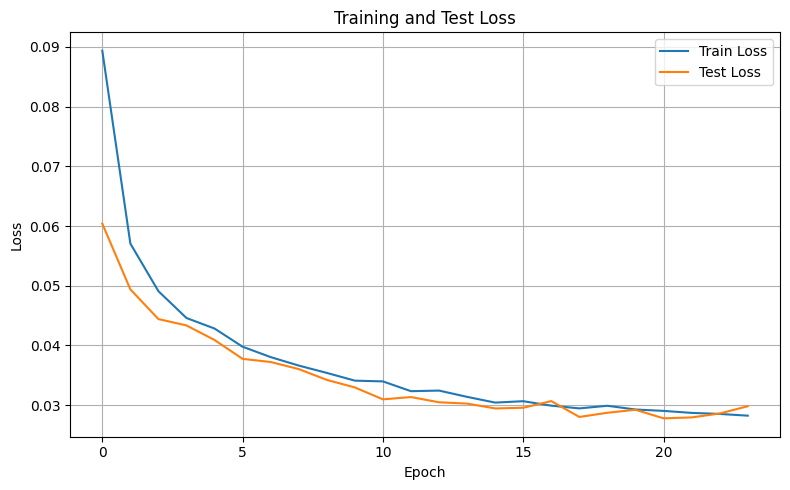

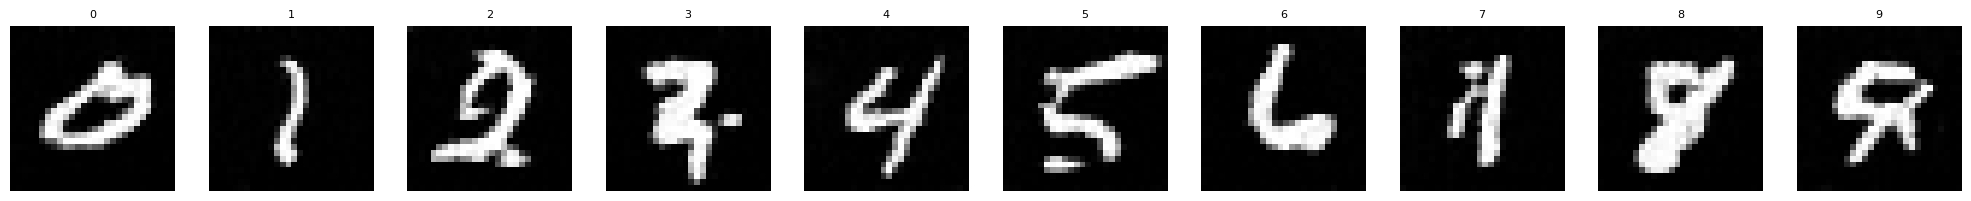

Sampling time (DDIM, prompt='numeric'): 0.15 seconds


In [ ]:
save_path_ddim_numeric = f"ddim_{prompt_type_ddim_numeric}.pt"

# Run training & sampling with DDIM
run_diffusion_pipeline_with_prompt_type(
    train_dataset=train_dataset_ddim_numeric,
    test_dataset=test_dataset_ddim_numeric,
    prompt_type=prompt_type_ddim_numeric,
    save_path=save_path_ddim_numeric,
    method='ddim',
    ddim_steps=50,
    eta=0.0,
    epochs=50,
    patience=3,
    min_delta=1e-4,
    measure_time=True,
    visualize=True
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ddim_numeric_model = DiffusionModel(device=device)
ddim_numeric_model.load_model("ddim_numeric.pt")  # use your trained DDIM model checkpoint
ddim_numeric_model.load_text_conditioned_data(train_dataset_ddim_numeric, test_dataset_ddim_numeric)

In [ ]:
fid_score_ddim_numeric = compute_fid_score(
    ddim_numeric_model,
    num_samples=1000,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.20MB/s]


FID (use_ddim=True): 114.6852


In [ ]:
is_score_ddim_numeric_mean, is_score_ddim_numeric_std = compute_inception_score(
    ddim_numeric_model,
    num_samples=1000,
    use_ddim=True
)

Inception Score (use_ddim=True): 1.4852 ± 0.0417


In [ ]:
prdc_scores_ddim_numeric = compute_prdc_score(
    ddim_numeric_model,
    num_samples=1000,
    nearest_k=5,
    use_ddim=True,
    ddim_steps=50,
    eta=0.0
)

PRDC (use_ddim=True):
precision: 0.2520
recall: 0.1590
density: 0.1838
coverage: 0.2520


# LDM

In [13]:
# === Autoencoder ===
class MNISTEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 64, 7, 7)
        return self.decoder(z)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = MNISTEncoder(latent_dim)
        self.decoder = MNISTDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [15]:
# === Autoencoder Training ===
def train_autoencoder(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            recon = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        print(f"[AE Training]: Epoch {epoch+1} | Loss: {total_loss / len(dataloader.dataset):.4f}")

In [16]:
# === Autoencoder Visualization ===
def visualize_reconstructions(model, dataloader, device, num_images=6):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x[:num_images].to(device)
    with torch.no_grad():
        recon = model(x)
    x = x.cpu()
    recon = recon.cpu()
    fig, axes = plt.subplots(2, num_images, figsize=(2 * num_images, 4))
    for i in range(num_images):
        axes[0, i].imshow(x[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

In [17]:
# === Latent Dataset Wrapper ===
class LatentMNISTDataset(Dataset):
    def __init__(self, base_dataset, encoder, device):
        self.dataset = base_dataset
        self.encoder = encoder.to(device)
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, text = self.dataset[idx]
        image = image.to(self.device)
        with torch.no_grad():
            latent = self.encoder(image.unsqueeze(0)).squeeze(0)
        return latent.cpu(), text

In [18]:
# === Denoiser for Latent Vectors ===
class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim=16, time_emb_dim=64, text_emb_dim=256):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim), nn.ReLU(), nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.text_proj = nn.Linear(text_emb_dim, time_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(latent_dim + time_emb_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z, t, text_emb):
        t_emb = self.time_embed(t.unsqueeze(1))
        text_emb = self.text_proj(text_emb)
        x = torch.cat([z, t_emb, text_emb], dim=1)
        return self.net(x)

In [19]:
class DiffusionModel:
    def __init__(self, autoencoder, device='cuda', timesteps=1000):
        self.device = device
        self.timesteps = timesteps
        self.model = LatentDenoiser().to(device)
        self.text_encoder = TextEncoder(device=device).to(device)
        self.autoencoder = autoencoder.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def get_noise_for_timestep(self, t, x0):
        noise = torch.randn_like(x0)
        s1 = self.sqrt_alphas_cumprod[t].view(-1, 1)
        s2 = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return s1 * x0 + s2 * noise, noise

    def train_step(self, x, text):
        x = x.to(self.device)
        t = torch.randint(0, self.timesteps, (x.shape[0],), device=self.device).long()
        noisy_x, noise = self.get_noise_for_timestep(t, x)
        text_emb = self.text_encoder(text)
        pred = self.model(noisy_x, t.float() / self.timesteps, text_emb)
        loss = self.loss_fn(pred, noise)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def test_step(self, x, text):
        x = x.to(self.device)
        t = torch.randint(0, self.timesteps, (x.shape[0],), device=self.device).long()
        noisy_x, noise = self.get_noise_for_timestep(t, x)
        text_emb = self.text_encoder(text)
        pred = self.model(noisy_x, t.float() / self.timesteps, text_emb)
        loss = self.loss_fn(pred, noise)
        return loss.item()

    def train_loop(self, train_loader, test_loader, epochs=10, patience=3, min_delta=1e-4, save_path="best_ldm_model.pt"):
        import time
        from tqdm import tqdm

        start_time = time.time()
        self.train_losses = []
        self.val_losses = []
        best_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            epoch_start = time.time()

            self.model.train()
            train_loss = 0.0
            for x, text in train_loader:
                train_loss += self.train_step(x, text)
            avg_train_loss = train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            self.model.eval()
            val_loss = 0.0
            for x, text in test_loader:
                val_loss += self.test_step(x, text)
            avg_val_loss = val_loss / len(test_loader)
            self.val_losses.append(avg_val_loss)

            duration = (time.time() - epoch_start) / 60
            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f} min")

            if best_loss - avg_val_loss > min_delta:
                best_loss = avg_val_loss
                patience_counter = 0
                self.save_model(save_path)
                print(f"Saved best model at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

        total_time = (time.time() - start_time) / 60
        print(f"\nTotal training time: {total_time:.2f} minutes")
        self.plot_loss_curves()
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
    
    def sample(self, text_prompts):
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(len(text_prompts), 16).to(self.device)
            text_emb = self.text_encoder(text_prompts)
            for i in reversed(range(self.timesteps)):
                t = torch.ones(len(text_prompts), device=self.device).long() * i
                eps = self.model(x, t.float() / self.timesteps, text_emb)
                alpha = self.alphas[i]
                alpha_cumprod = self.alphas_cumprod[i]
                beta = self.betas[i]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * eps) + torch.sqrt(beta) * noise
            decoded = torch.stack([self.autoencoder.decoder(z.unsqueeze(0)).squeeze(0).cpu() for z in x])
            return decoded

    def plot_loss_curves(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("LDM Loss Curves")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def visualize_samples(self, samples, prompts):
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, len(samples), figsize=(2 * len(samples), 2))
        for i in range(len(samples)):
            ax = axes[i] if len(samples) > 1 else axes
            ax.imshow(samples[i][0], cmap='gray')
            ax.set_title(prompts[i], fontsize=8)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
autoencoder = Autoencoder().to(device)

transform = Compose([Resize((28, 28)), ToTensor()])
mnist_dataset = MNISTTextDataset(transform, targets_to_text_fn=long_prompt)

ae_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_autoencoder(autoencoder, ae_loader, optimizer, criterion, device, epochs=15)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



[AE Training]: Epoch 1 | Loss: 0.0217
[AE Training]: Epoch 2 | Loss: 0.0110
[AE Training]: Epoch 3 | Loss: 0.0097
[AE Training]: Epoch 4 | Loss: 0.0091
[AE Training]: Epoch 5 | Loss: 0.0087
[AE Training]: Epoch 6 | Loss: 0.0085
[AE Training]: Epoch 7 | Loss: 0.0082
[AE Training]: Epoch 8 | Loss: 0.0081
[AE Training]: Epoch 9 | Loss: 0.0079
[AE Training]: Epoch 10 | Loss: 0.0078
[AE Training]: Epoch 11 | Loss: 0.0077
[AE Training]: Epoch 12 | Loss: 0.0076
[AE Training]: Epoch 13 | Loss: 0.0076
[AE Training]: Epoch 14 | Loss: 0.0075
[AE Training]: Epoch 15 | Loss: 0.0074


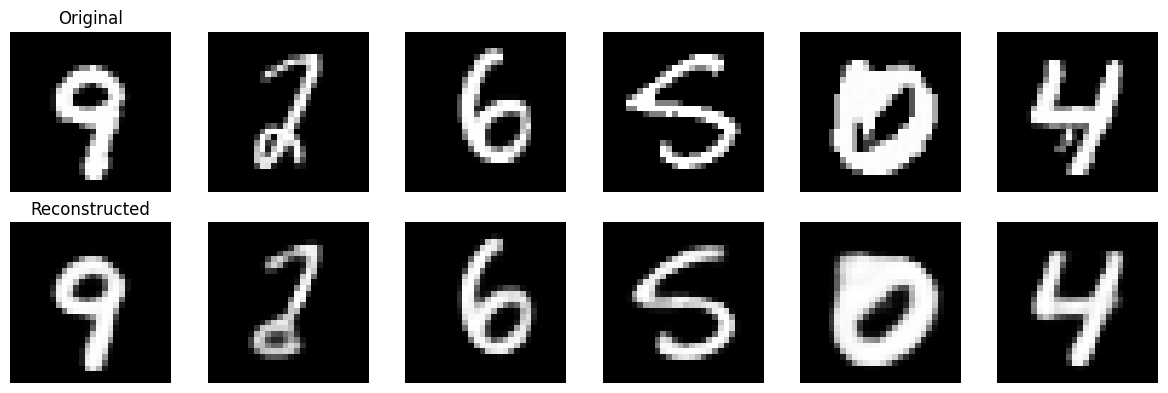

In [22]:
visualize_reconstructions(autoencoder, ae_loader, device)

In [24]:
latent_dataset = LatentMNISTDataset(mnist_dataset, autoencoder.encoder, device)

train_size = int(0.8 * len(latent_dataset))
test_size = len(latent_dataset) - train_size
latent_train_dataset, latent_test_dataset = random_split(latent_dataset, [train_size, test_size])

train_loader = DataLoader(latent_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(latent_test_dataset, batch_size=64, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training Epochs:   7%|▋         | 1/15 [01:12<16:52, 72.31s/it]

Epoch 1, Train Loss: 0.4143, Val Loss: 0.3392, Time: 1.21 min
Saved best model at epoch 1 with val loss: 0.3392


Training Epochs:  13%|█▎        | 2/15 [02:24<15:39, 72.25s/it]

Epoch 2, Train Loss: 0.3354, Val Loss: 0.3248, Time: 1.20 min
Saved best model at epoch 2 with val loss: 0.3248


Training Epochs:  20%|██        | 3/15 [03:36<14:26, 72.20s/it]

Epoch 3, Train Loss: 0.3240, Val Loss: 0.3259, Time: 1.20 min
No improvement. Patience: 1/3


Training Epochs:  27%|██▋       | 4/15 [04:48<13:13, 72.16s/it]

Epoch 4, Train Loss: 0.3145, Val Loss: 0.3106, Time: 1.20 min
Saved best model at epoch 4 with val loss: 0.3106


Training Epochs:  33%|███▎      | 5/15 [06:00<12:01, 72.11s/it]

Epoch 5, Train Loss: 0.3111, Val Loss: 0.3117, Time: 1.20 min
No improvement. Patience: 1/3


Training Epochs:  40%|████      | 6/15 [07:13<10:49, 72.20s/it]

Epoch 6, Train Loss: 0.3097, Val Loss: 0.3073, Time: 1.21 min
Saved best model at epoch 6 with val loss: 0.3073


Training Epochs:  47%|████▋     | 7/15 [08:25<09:37, 72.19s/it]

Epoch 7, Train Loss: 0.3069, Val Loss: 0.3046, Time: 1.20 min
Saved best model at epoch 7 with val loss: 0.3046


Training Epochs:  53%|█████▎    | 8/15 [09:37<08:25, 72.23s/it]

Epoch 8, Train Loss: 0.3048, Val Loss: 0.2993, Time: 1.21 min
Saved best model at epoch 8 with val loss: 0.2993


Training Epochs:  60%|██████    | 9/15 [10:49<07:12, 72.17s/it]

Epoch 9, Train Loss: 0.3035, Val Loss: 0.3053, Time: 1.20 min
No improvement. Patience: 1/3


Training Epochs:  67%|██████▋   | 10/15 [12:01<06:00, 72.17s/it]

Epoch 10, Train Loss: 0.3013, Val Loss: 0.3062, Time: 1.20 min
No improvement. Patience: 2/3


Training Epochs:  67%|██████▋   | 10/15 [13:13<06:36, 79.36s/it]

Epoch 11, Train Loss: 0.2995, Val Loss: 0.3082, Time: 1.20 min
No improvement. Patience: 3/3
Early stopping triggered at epoch 11.

Total training time: 13.23 minutes


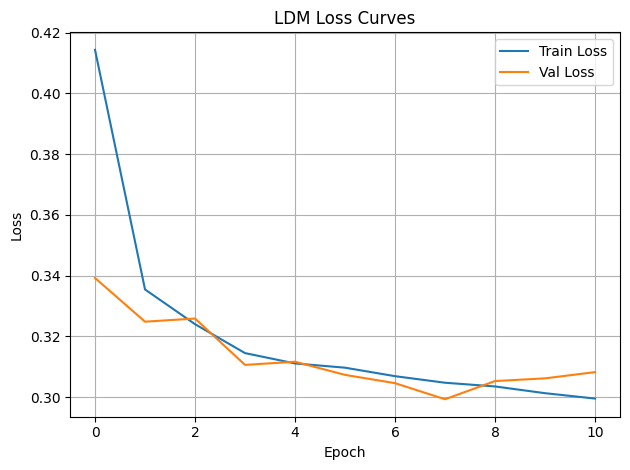

In [25]:
ldm = DiffusionModel(autoencoder, device=device)

ldm.train_loop(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=15,
    patience=3,
    min_delta=1e-3,
    save_path="/kaggle/working/ldm_best.pt"
)

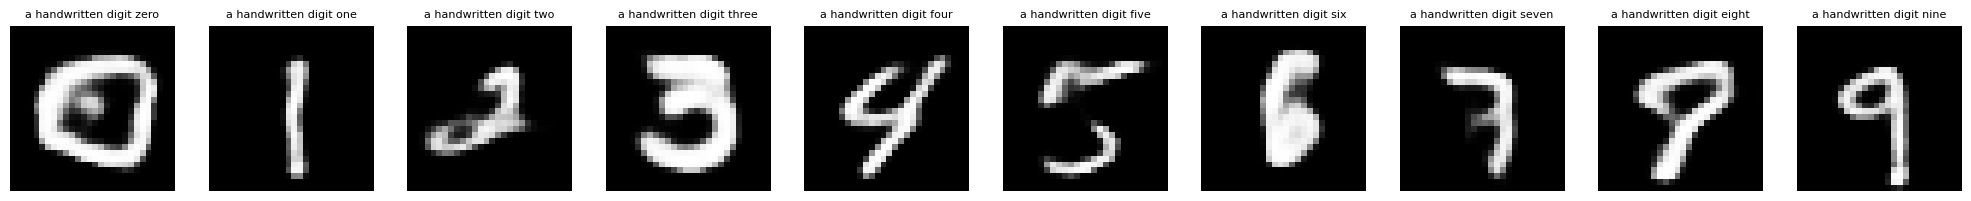

In [26]:
prompts_ldm = [
    "a handwritten digit zero",
    "a handwritten digit one",
    "a handwritten digit two",
    "a handwritten digit three",
    "a handwritten digit four",
    "a handwritten digit five",
    "a handwritten digit six",
    "a handwritten digit seven",
    "a handwritten digit eight",
    "a handwritten digit nine"
]
samples_ldm = ldm.sample(prompts_ldm)

ldm.visualize_samples(samples_ldm, prompts_ldm)

### Metrics LDM

#### FID

In [27]:
def compute_fid_score_ldm(model, num_samples=1000):
    device = model.device

    inception = inception_v3(pretrained=True, aux_logits=True).to(device)
    inception.fc = nn.Identity()
    inception.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    real_dataset = MNIST(root=".", train=True, download=True, transform=transform)
    real_loader = DataLoader(real_dataset, batch_size=64, shuffle=True)

    real_images = []
    for img, _ in real_loader:
        real_images.append(img)
        if len(real_images) * 64 >= num_samples:
            break
    real_images = torch.cat(real_images)[:num_samples].to(device)

    prompts = [f"a handwritten digit {i % 10}" for i in range(num_samples)]
    fake_images = model.sample(prompts).to(device)
    fake_images = F.interpolate(fake_images, size=(299, 299), mode="bilinear", align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])(fake_images)

    def get_features(images):
        feats = []
        with torch.no_grad():
            for i in range(0, len(images), 64):
                batch = images[i:i + 64]
                pred = inception(batch)
                feats.append(pred.cpu().numpy())
        return np.concatenate(feats, axis=0)

    real_feats = get_features(real_images)
    fake_feats = get_features(fake_images)

    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_feats, axis=0), np.cov(fake_feats, rowvar=False)
    covmean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    print(f"FID: {fid:.4f}")
    return fid

#### CLIP

In [28]:
def compute_clip_score_ldm(model, prompt_type='long', samples_per_prompt=5):
    device = model.device

    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model.eval()

    prompt_map = {
        'numeric': [str(i) for i in range(10)],
        'digit': [f"digit {i}" for i in range(10)],
        'long': [f"a handwritten digit {w}" for w in [
            "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"
        ]]
    }

    assert prompt_type in prompt_map
    prompts = prompt_map[prompt_type]

    print(f"\n Evaluating CLIP score for prompt type: '{prompt_type}'")
    all_scores = []

    to_pil = transforms.ToPILImage()
    for prompt in prompts:
        text_batch = [prompt] * samples_per_prompt
        images = model.sample(text_batch).cpu()
        pil_images = [to_pil(img.squeeze(0)).resize((224, 224)).convert("RGB") for img in images]

        inputs = clip_processor(text=text_batch, images=pil_images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            scores = logits_per_image.squeeze().cpu().numpy()
            all_scores.extend(scores)

    avg_score = float(np.mean(all_scores))
    print(f"CLIP Score for '{prompt_type}': {avg_score:.4f}")
    return avg_score

#### Inception Score

In [29]:
def compute_inception_score_ldm(ldm, num_samples=1000, splits=10):
    device = ldm.device

    inception = inception_v3(pretrained=True, aux_logits=True).to(device)
    inception.eval()

    prompts = [f"a handwritten digit {i % 10}" for i in range(num_samples)]
    images = ldm.sample(prompts).to(device)

    images = (images.clamp(0, 1))
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = images.repeat(1, 3, 1, 1)

    preds = []
    with torch.no_grad():
        for i in range(0, num_samples, 64):
            batch = images[i:i+64]
            logits = inception(batch)
            probs = F.softmax(logits, dim=1)
            preds.append(probs.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []

    split_size = num_samples // splits
    for i in range(splits):
        part = preds[i * split_size:(i + 1) * split_size]
        py = np.mean(part, axis=0)
        kl_div = part * (np.log(part + 1e-10) - np.log(py + 1e-10))
        kl_div = np.sum(kl_div, axis=1)
        scores.append(np.exp(np.mean(kl_div)))

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"Inception Score: {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score

#### PRDC score

In [30]:
def compute_prdc_score_ldm(ldm, num_samples=1000, nearest_k=5):
    device = ldm.device

    inception = inception_v3(pretrained=True, aux_logits=True).to(device)
    inception.fc = nn.Identity()
    inception.eval()

    def extract_features(images):
        feats = []
        with torch.no_grad():
            for i in range(0, len(images), 64):
                feats.append(inception(images[i:i+64]).cpu().numpy())
        return np.concatenate(feats, axis=0)

    # === Real Images ===
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    mnist = MNIST(root=".", train=True, download=True, transform=transform)
    real_loader = DataLoader(mnist, batch_size=64, shuffle=True)

    real_images = []
    for x, _ in real_loader:
        real_images.append(x)
        if len(real_images) * 64 >= num_samples:
            break
    real_images = torch.cat(real_images)[:num_samples].to(device)

    # === Fake Images ===
    prompts = [f"a handwritten digit {i % 10}" for i in range(num_samples)]
    fake_images = ldm.sample(prompts).clamp(0, 1).to(device)
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear')
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])(fake_images)

    real_feats = extract_features(real_images)
    fake_feats = extract_features(fake_images)

    from scipy.spatial import cKDTree

    real_tree = cKDTree(real_feats)
    fake_tree = cKDTree(fake_feats)

    real_nn_dists = real_tree.query(real_feats, k=nearest_k + 1)[0][:, -1]
    fake_nn_dists = fake_tree.query(fake_feats, k=nearest_k + 1)[0][:, -1]

    def precision():
        dists = real_tree.query(fake_feats, k=1)[0]
        return (dists <= real_nn_dists).mean()

    def recall():
        dists = fake_tree.query(real_feats, k=1)[0]
        return (dists <= fake_nn_dists).mean()

    def density():
        dists = real_tree.query(fake_feats, k=nearest_k)[0]
        return (dists <= real_nn_dists[:, None]).sum() / (nearest_k * len(fake_feats))

    def coverage():
        dists = real_tree.query(fake_feats, k=1)[0]
        return (dists <= real_nn_dists).sum() / len(real_nn_dists)

    metrics = {
        'precision': precision(),
        'recall': recall(),
        'density': density(),
        'coverage': coverage(),
    }

    print("PRDC Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

#### Calculations

In [31]:
fid = compute_fid_score_ldm(ldm, num_samples=1000)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 185MB/s]  


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 40.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 14.3MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

FID: 55.6817


In [32]:
clip_score = compute_clip_score_ldm(ldm, prompt_type='long', samples_per_prompt=5)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


 Evaluating CLIP score for prompt type: 'long'
CLIP Score for 'long': 26.6867


In [33]:
compute_inception_score_ldm(ldm, num_samples=1000, splits=10)

Inception Score: 2.1475 ± 0.1253


(2.1475203, 0.12533092)

In [34]:
compute_prdc_score_ldm(ldm, num_samples=1000, nearest_k=5)

PRDC Metrics:
precision: 0.3380
recall: 0.4290
density: 0.2410
coverage: 0.3380


{'precision': 0.338, 'recall': 0.429, 'density': 0.241, 'coverage': 0.338}